<a href="https://colab.research.google.com/github/gabrielmelo00/Machine-Learning-Projects/blob/main/Spectral_Estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Practical work on spectral estimation**


Gabriel Silva Vieira de Melo

Gabriela Barbosa Guedes Pereira






In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install PyAudio
!pip install soundfile

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import signal as sig
from scipy import linalg as la
import librosa

import os, sys, wave, struct

import pyaudio
import pandas as pd


from copy import deepcopy
from math import ceil
from scipy.io.wavfile import write

import soundfile as sf
from IPython.display import Audio

import time

ModuleNotFoundError: ignored

## **1 Autoregressive process**


### **1.1 Synthesis**


In [ ]:
#function to synthesize an AR process

def AR(N,var,a_coef):
  Xt = np.zeros(N)
  Zt = np.random.normal(0, var, size = N)
  Xt[0] = Zt[0]
  for i in range(1,N):
    aux = 0 
    for j in range(1,len(a_coef)+1):
      if(i - j >= 0):
        aux += a_coef[j - 1]*Xt[i - j]
    Xt[i] = Zt[i] + aux
  return Xt

Testing the function, synthesizing an AR(1) process:

In [ ]:
var = 1
a1 = 0.5
N = 500
Xt = AR(N,var,[a1])
print("Size of the random process:",len(Xt))

Size of the random process: 500


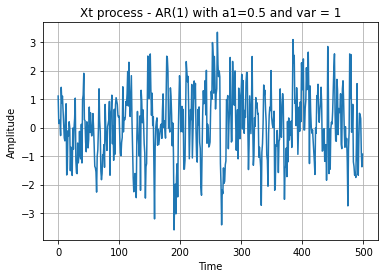

In [ ]:
plt.figure()
plt.title(f"Xt process - AR(1) with a1={a1} and var = {var}")
plt.plot(Xt)
plt.grid()
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

We know that the power spectal density of an AR(1) process is given by

\begin{equation}
S_{XX}(\nu) = \frac{\sigma^2}{|1- a_1 e^{-2\pi i \nu}|^2}
\end{equation}

In [ ]:
def PSD_AR1(N, var, a1):
  freq = np.linspace(0,1,N)
  psd = var/np.abs(1 - a1*np.exp(-2*1j*np.pi*freq))**2
  return psd 

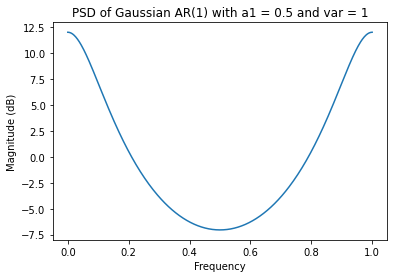

In [ ]:
#calculating the psd
psd = PSD_AR1(N,var,a1)

#plotting the psd in dB
plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd))
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title(f'PSD of Gaussian AR(1) with a1 = {a1} and var = {var}')
plt.show()

### **1.2 Non-parametric estimation: periodogram**

Coding the function that computes and displays the periodogram of a given input signal, such that we can choose the method that the function will calculate the periodogram:


*   Standard
*   Bartlett
*   Welsh





In [ ]:
#Function to compute the periodogram

def Periodogram(Xt, method = None, M = None):
  if(M == None):
    M = 100
  N = len(Xt)

  if(method == None or method == 'Standard'):
    Spxx = (1/N)*np.abs(np.fft.fft(Xt))**2

  if(method == 'Bartlett'):
    L = int(N/M)
    Xtilde = Xt.reshape(int(L),int(M))
    Spxx = np.zeros(M)
    for i in range(L):
      Spxx = Spxx + (1/M)*(np.abs(np.fft.fft(Xtilde[i]))**2)
    Spxx = (1/L)*Spxx
    
  if(method == 'Welsh'):
    K = int(M/2) 
    S = int(2*N/M)
    v_t = signal.windows.hamming(K)
    P = np.sum(np.abs(signal.windows.hamming(M))**2)/N
    Xtilde = Xt.reshape(int(S),int(K))
    Spxx = np.zeros(M)
    for i in range(S):
      Spxx = Spxx + (1/(M*P))*(np.abs(np.fft.fft(Xtilde[i]*v_t, M))**2)
    Spxx = Spxx/S

  return Spxx

Testing the function that calculates the periodogram applied to the AR(1) process ``` Xt ``` defined in the previous section of this notebook [[Section 1.1](https://colab.research.google.com/drive/1B0MBDrGawnmox4kFb9-2o9al_doM2SNl#scrollTo=cm-Ipicir4DF)]. 



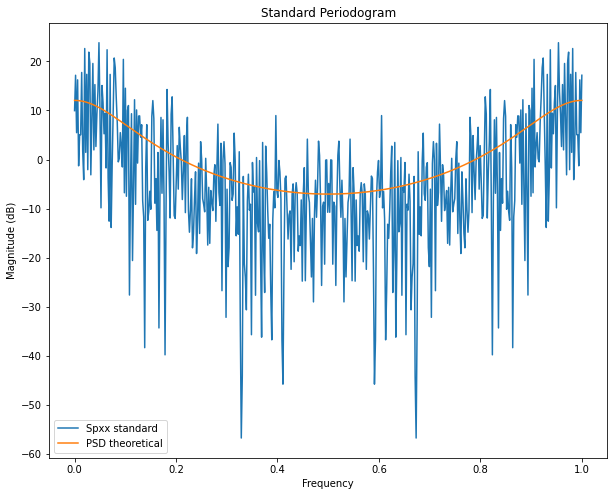

In [ ]:
Spxx = Periodogram(Xt,'Standard')

#plotting the periodogram in dB
plt.figure(figsize = (10,8))
plt.plot(np.linspace(0,1,len(Spxx)), 20*np.log10(Spxx), label = 'Spxx standard')
plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD theoretical')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('Standard Periodogram')
plt.legend()
plt.show()

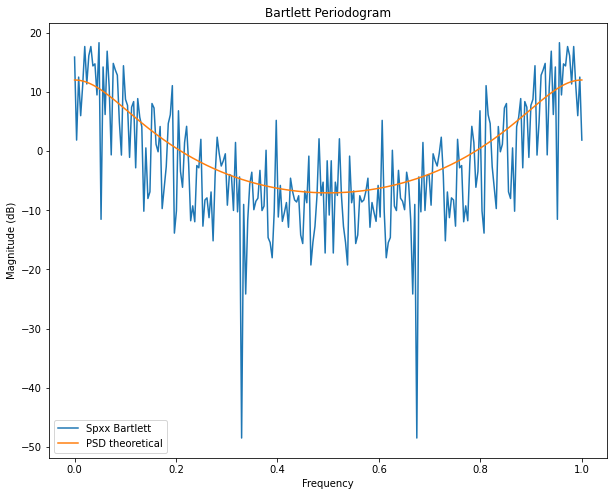

In [ ]:
Spxx_B = Periodogram(Xt, 'Bartlett', M = 250)

#plotting the periodogram in dB
plt.figure(figsize = (10,8))
plt.plot(np.linspace(0,1,len(Spxx_B)), 20*np.log10(Spxx_B), label = 'Spxx Bartlett')
plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD theoretical')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('Bartlett Periodogram')
plt.legend()
plt.show()

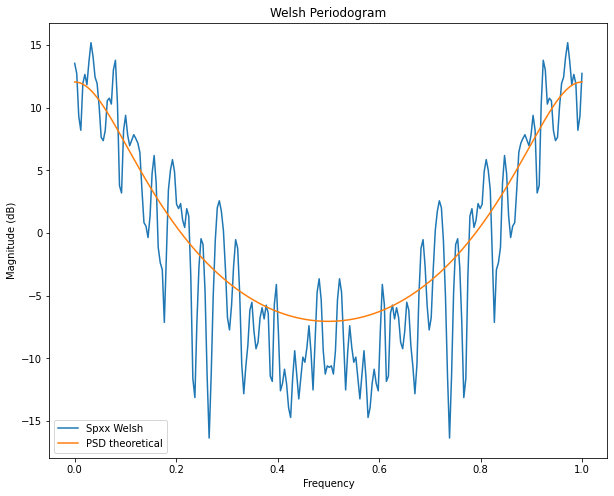

In [ ]:
Spxx_W = Periodogram(Xt, 'Welsh', M = 250)

#plotting the periodogram in dB
plt.figure(figsize = (10,8))
plt.plot(np.linspace(0,1,len(Spxx_W)), 20*np.log10(Spxx_W), label = 'Spxx Welsh')
plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD theoretical')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('Welsh Periodogram')
plt.legend()
plt.show()

There is less smearing effect if we use the Welch method.  However, the Bartlett method already decreases the smearing effect with respect to the periodogram of the standard estimator.

In [ ]:
#Calculating the Bias and  Variance 

#Standard Estimator
bias_std = np.mean(Spxx) - np.mean(psd)
var_std = np.var(Spxx)

#Bartlett Estimator
bias_B = np.mean(Spxx_B) - np.mean(psd)
var_B = np.var(Spxx_B)

#Welsh Estimator
bias_W = np.mean(Spxx_W) - np.mean(psd)
var_W = np.var(Spxx_W)

print('** Standard Estimator **')
print('bias:', bias_std)
print('variance:', var_std)
print('\n')

print('** Bartlett Estimator **')
print('bias:', bias_B)
print('variance:', var_B)
print('\n')

print('** Welsh Estimator **')
print('bias:', bias_W)
print('variance:', var_W)

** Standard Estimator **
bias: 0.11795051417590963
variance: 5.935233262755508


** Bartlett Estimator **
bias: 0.11795051417590963
variance: 3.294160798867073


** Welsh Estimator **
bias: 0.012949319696748729
variance: 1.736944522777566


As we can see, the Welsh and the Bartlett method reduce the variance when we compare with the Standard estimator. Also, the value of bartlett variance is closer to the welsh variance. Regarding bias, the smallest bias was presented by the Welsh method. 

### **1.3 Parametric estimation: linear prediction**

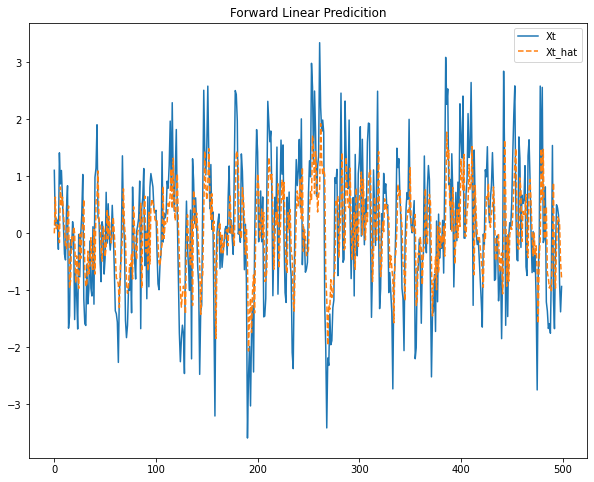

In [ ]:
#Calculating the forward linear prediction (Xt_hat) to estimate the AR model
a = librosa.lpc(Xt, order=1)
b = np.hstack([[0], -1 * a[1:]])
Xt_hat = signal.lfilter(b, [1], Xt)

#Plotting the linear prediction 
plt.figure(figsize = (10,8))
plt.plot(Xt, label = 'Xt')
plt.plot(Xt_hat, linestyle='--', label = 'Xt_hat')
plt.legend()
plt.title('Forward Linear Predicition')
plt.show()

In [ ]:
#Using the code of TSIA 202a

def acovb(X=None):

    Xc = X - np.mean(X)    
    m = 2 * X.size - 1
    I = np.abs(np.fft.fft(Xc,m)) ** 2 /  X.size
    gamma = np.real(np.fft.ifft(I))    
    gamma = gamma[0:X.size]
    return gamma

def estimateAr(X, p):

    gamma = acovb(X)
    Gamma_hat = la.toeplitz(gamma[0:p+1])

    v1 = np.zeros(p+1)
    v1[0]=1
    c = np.dot(la.inv(Gamma_hat),v1)

    sigma2Est = 1/c[0]
    estimated_coeff= c * sigma2Est

    return estimated_coeff, sigma2Est

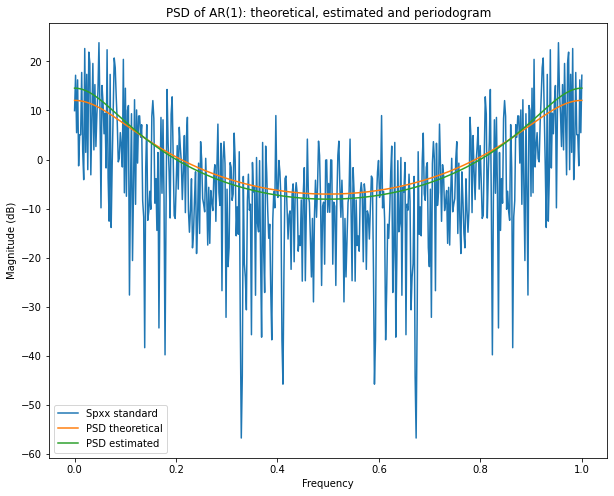



*** Comparison between estimated and theoretical values ***
Estimated coefficient:  0.5722898924354697
Theoretical coefficient:  0.5
Estimated variance:  0.9753210706590448
Theoretical variance:  1


In [ ]:
estimated_coeff, sigma2Est = estimateAr(Xt, 1)

psd_estimated = PSD_AR1(N,sigma2Est,-estimated_coeff[1])


#% Plotting the estimated psd
plt.figure(figsize = (10,8))
plt.plot(np.linspace(0,1,len(Spxx)), 20*np.log10(Spxx), label = 'Spxx standard')
plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD theoretical')
plt.plot(np.linspace(0,1,len(psd_estimated)), 20*np.log10(psd_estimated), label = 'PSD estimated')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('PSD of AR(1): theoretical, estimated and periodogram')
plt.legend()
plt.show()

print('\n')
print('*** Comparison between estimated and theoretical values ***')
print('Estimated coefficient: ', -estimated_coeff[1])
print('Theoretical coefficient: ', a1)
print('Estimated variance: ', sigma2Est)
print('Theoretical variance: ', var) 

In [ ]:
#Calculating the error

error_a1 = (-estimated_coeff[1] - a1)/a1
print(f'The estimated a1 coefficient has an error of {round(error_a1*100, 2)}%')

error_sig = (sigma2Est - var)/var
print(f'The estimated variance has an error of {round(error_sig*100, 2)}%')

The estimated a1 coefficient has an error of 14.46%
The estimated variance has an error of -2.47%


### **1.4 Application to speech signal**

In [ ]:
#Using the code from TP1 TSIA201

def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk)

    stream.stop_stream()
    stream.close()
    p.terminate()
    
def plot_sound(data, times, title = ' '):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    plt.title(title)
    plt.show()

In [ ]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

In [ ]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [ ]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)

In [ ]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

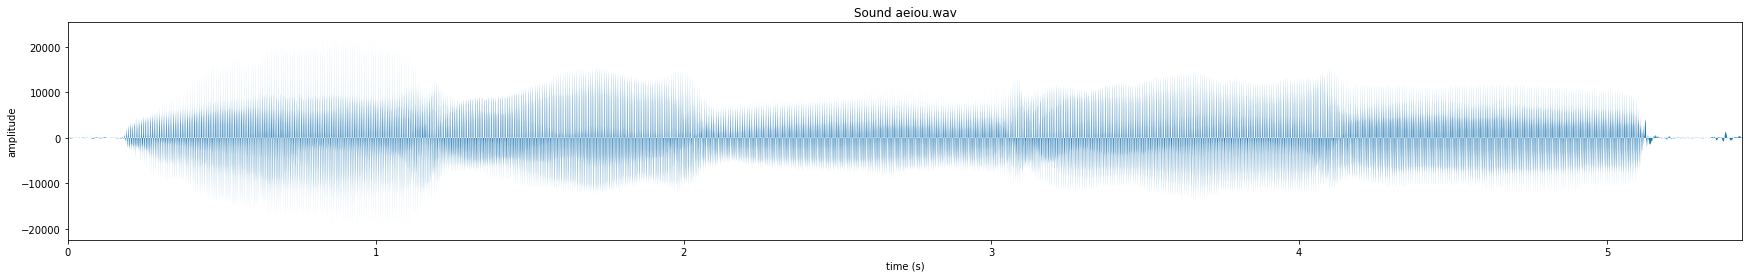

In [ ]:
plot_sound(x, times, 'Sound aeiou.wav')

In [ ]:
Audio(x, rate = Fs)

By seeing the graph and listening to the audio we can conclude that the sound of the 'A' vowel is between 0.2 and 1.0 seconds. So, we can separate just the sound of the 'A' vowel by adjusting manually. 

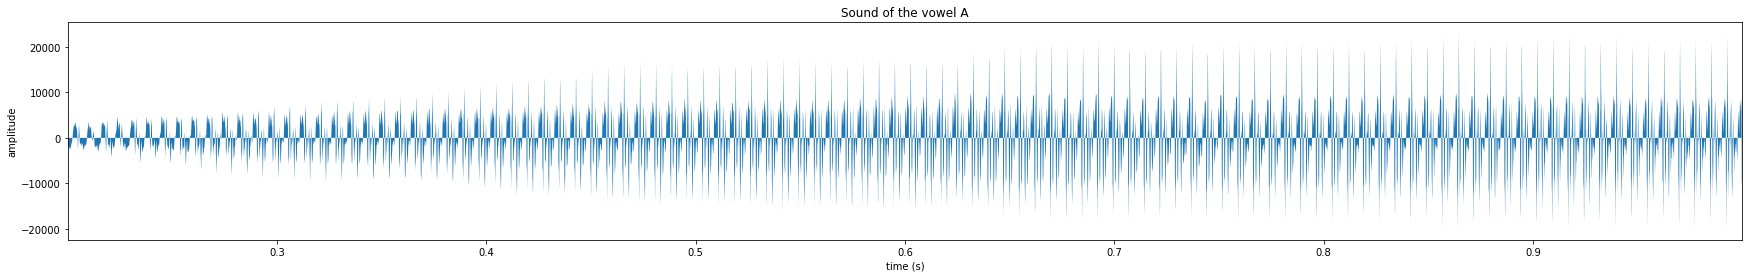

In [ ]:
#Separating the vowel A
a_begin = np.argmax(times>0.2)
a_end = np.argmin(times<1.0)
vowel_a = x[a_begin:a_end]
time_a = times[a_begin:a_end]
plot_sound(vowel_a, time_a, 'Sound of the vowel A')

So we can listen only the vowel A

In [ ]:
Audio(vowel_a, rate = Fs)

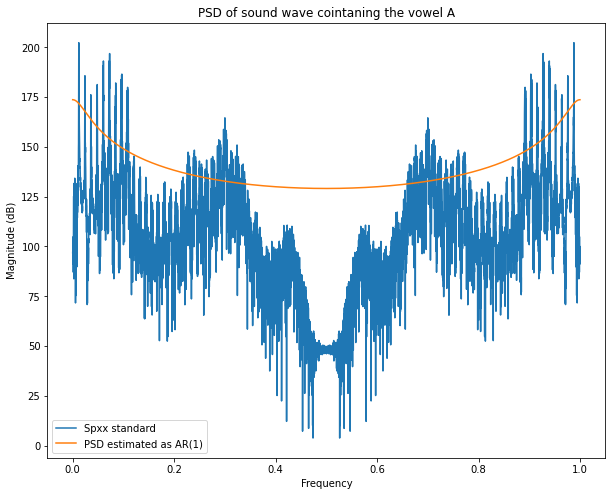



***  Estimated values ***
Estimated coefficient:  0.8572446773352438
Estimated variance:  9856808.020088809


In [ ]:
#Estimating the parameters of the audio containing only the vowel A
N = len(vowel_a)
estimated_coeff, sigma2Est = estimateAr(vowel_a, 1)
psd_estimated = PSD_AR1(N,sigma2Est,-estimated_coeff[1])

#Calculating the periodogram of the audio containing only the vowel A
Spxx = Periodogram(vowel_a,'Standard')

#% Plotting 
plt.figure(figsize = (10,8))
plt.plot(np.linspace(0,1,len(Spxx)), 20*np.log10(Spxx), label = 'Spxx standard')
plt.plot(np.linspace(0,1,len(psd_estimated)), 20*np.log10(psd_estimated), label = 'PSD estimated as AR(1)')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('PSD of sound wave cointaning the vowel A')
plt.legend()
plt.show()

print('\n')
print('***  Estimated values ***')
print('Estimated coefficient: ', -estimated_coeff[1])
print('Estimated variance: ', sigma2Est)

As we can see by this graph, the sound wave of the vowel A is not well represented by the AR(1) model. Because the content of the estimated spectra does not match with periodogram.

## **2 Sum of noisy sinusoids** 

### **2.1 Synthesis**

In [ ]:
#function to synthesize a sum of sinusoids

def Sinusoids(N, K, freq, amp, phases, var):
  Xt = np.zeros(N)
  Zt = np.random.normal(0, var, size = N)
  for t in range(1,N):
    aux = 0 
    for j in range(K):
      aux += amp[j]*np.sin(2*np.pi*freq[j]*t + phases[j])
    Xt[t] = Zt[t] + aux
  return Xt

In [ ]:
N = 100
K = 2
freq = [0.4, 0.2]
amp = [1, 2]
phases = [0, np.pi]
var = 1
Xt = Sinusoids(N, K, freq, amp, phases, var)

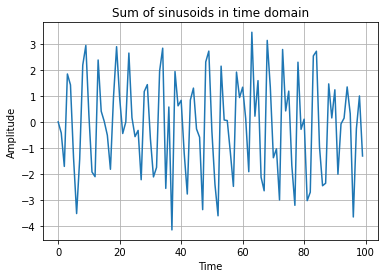

In [ ]:
plt.figure()
plt.title(f"Sum of sinusoids in time domain")
plt.plot(Xt)
plt.grid()
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

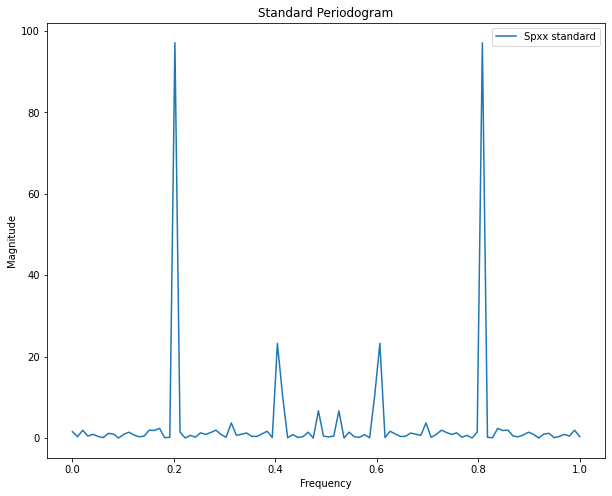

In [ ]:
Spxx = Periodogram(Xt,'Standard')

#plotting the periodogram 
plt.figure(figsize = (10,8))
plt.plot(np.linspace(0,1,len(Spxx)), Spxx, label = 'Spxx standard')
plt.ylabel('Magnitude')
plt.xlabel('Frequency')
plt.title('Standard Periodogram')
plt.legend()
plt.show()

We can notice that the peaks of the spectogram are in the fundamental frequencies of the sines.

### **2.2 Non parametric estimation: periodogram**

In [ ]:
#Generating sinusoid
N = 500
K = 2
v1 = 0.4
v2 = 0.2
freq = [v1, v2]
amp = [1, 1]
phases = [0, 0]
var = 1
Xt = Sinusoids(N, K, freq, amp, phases, var)

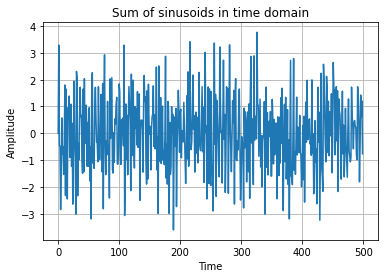

In [ ]:
plt.figure()
plt.title(f"Sum of sinusoids in time domain")
plt.plot(Xt)
plt.grid()
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

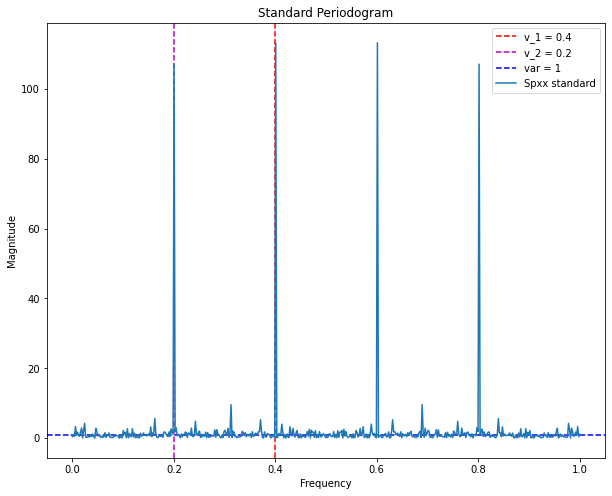

In [ ]:
Spxx = Periodogram(Xt,'Standard')

#plotting the periodogram 
plt.figure(figsize = (10,8))
plt.axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
plt.axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
plt.axhline(var, color='b', ls='--',label = f'var = {var}')
plt.plot(np.linspace(0,1,len(Spxx)), Spxx, label = 'Spxx standard')
plt.ylabel('Magnitude')
plt.xlabel('Frequency')
plt.title('Standard Periodogram')
plt.legend()
plt.show()

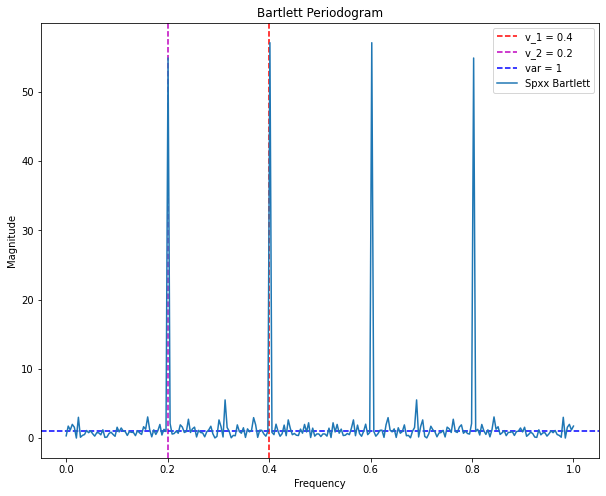

In [ ]:
Spxx_B = Periodogram(Xt, 'Bartlett', M = 250)

#plotting the periodogram 
plt.figure(figsize = (10,8))
plt.axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
plt.axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
plt.axhline(var, color='b', ls='--',label = f'var = {var}')
plt.plot(np.linspace(0,1,len(Spxx_B)), Spxx_B, label = 'Spxx Bartlett')
plt.ylabel('Magnitude')
plt.xlabel('Frequency')
plt.title('Bartlett Periodogram')
plt.legend()
plt.show()

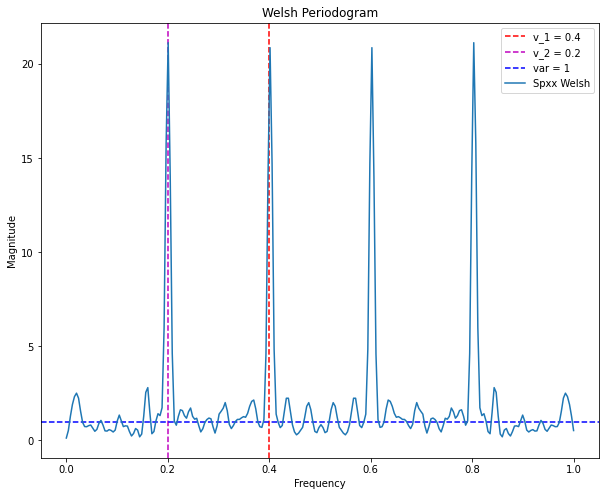

In [ ]:
Spxx_W = Periodogram(Xt, 'Welsh', M = 250)

#plotting the periodogram 
plt.figure(figsize = (10,8))
plt.axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
plt.axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
plt.axhline(var, color='b', ls='--',label = f'var = {var}')
plt.plot(np.linspace(0,1,len(Spxx_W)), Spxx_W, label = 'Spxx Welsh')
plt.ylabel('Magnitude')
plt.xlabel('Frequency')
plt.title('Welsh Periodogram')
plt.legend()
plt.show()

Now we want to compare the resolution of various periodograms, by varying $Δν =|\nu_1 - \nu_2|  $

In [ ]:
N = 500
K = 2
amp = [1, 1]
phases = [0, 0]
var = 1
v1 = 0.4
v2 = [0.2, 0.3, 0.35, 0.39]
Xt_vect = []
delta = []
for i in range(len(v2)):
  freq = [v1,v2[i]]
  delta.append(np.abs(v1 - v2[i]))
  Xt_vect.append(Sinusoids(N, K, freq, amp, phases, var))

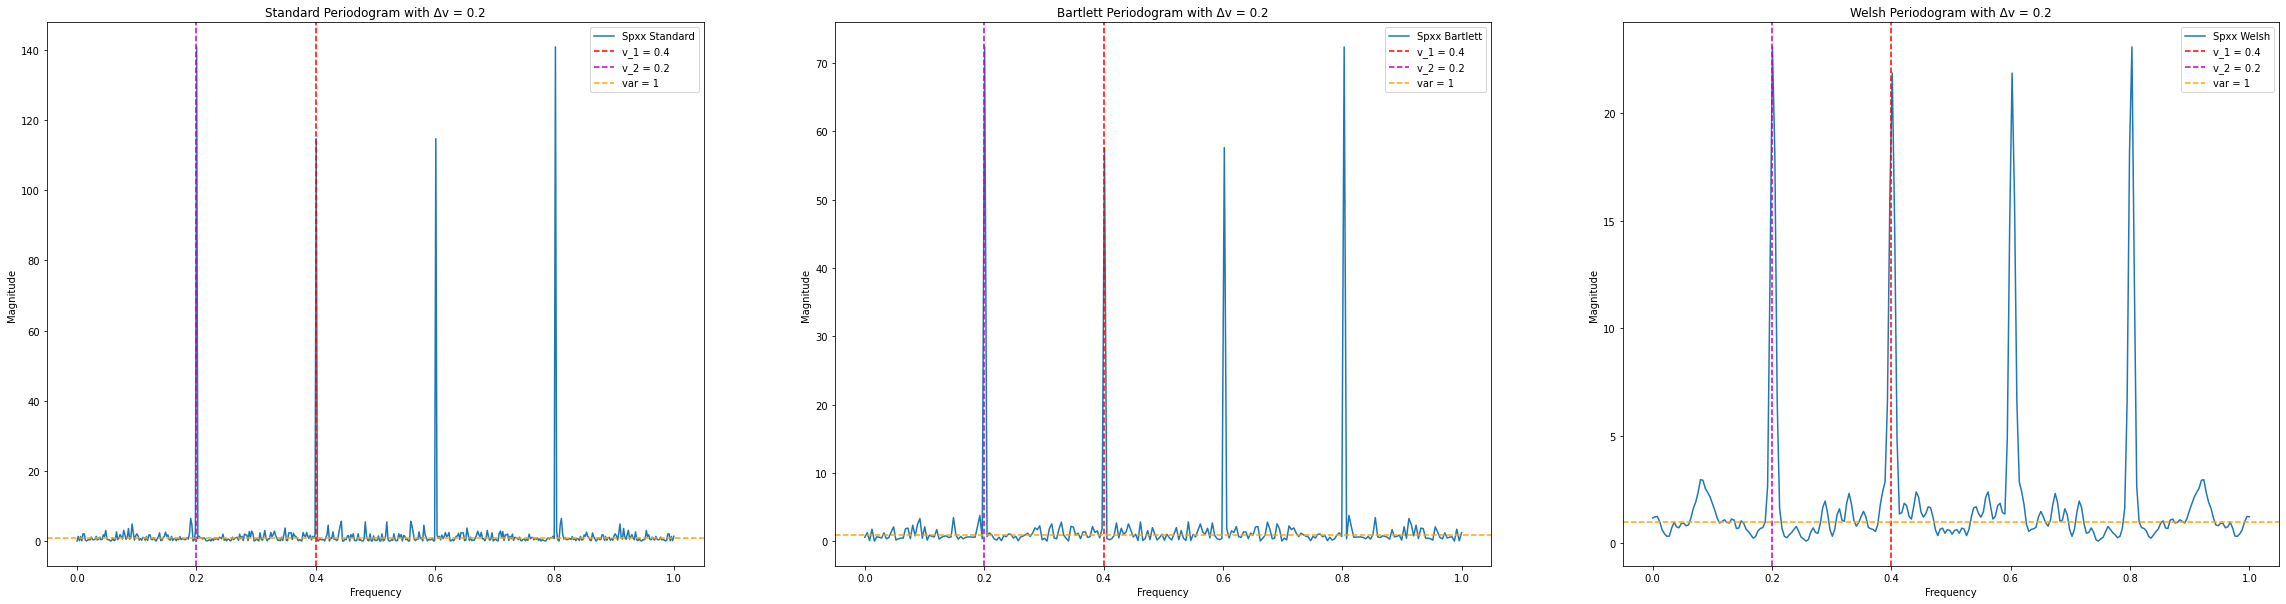

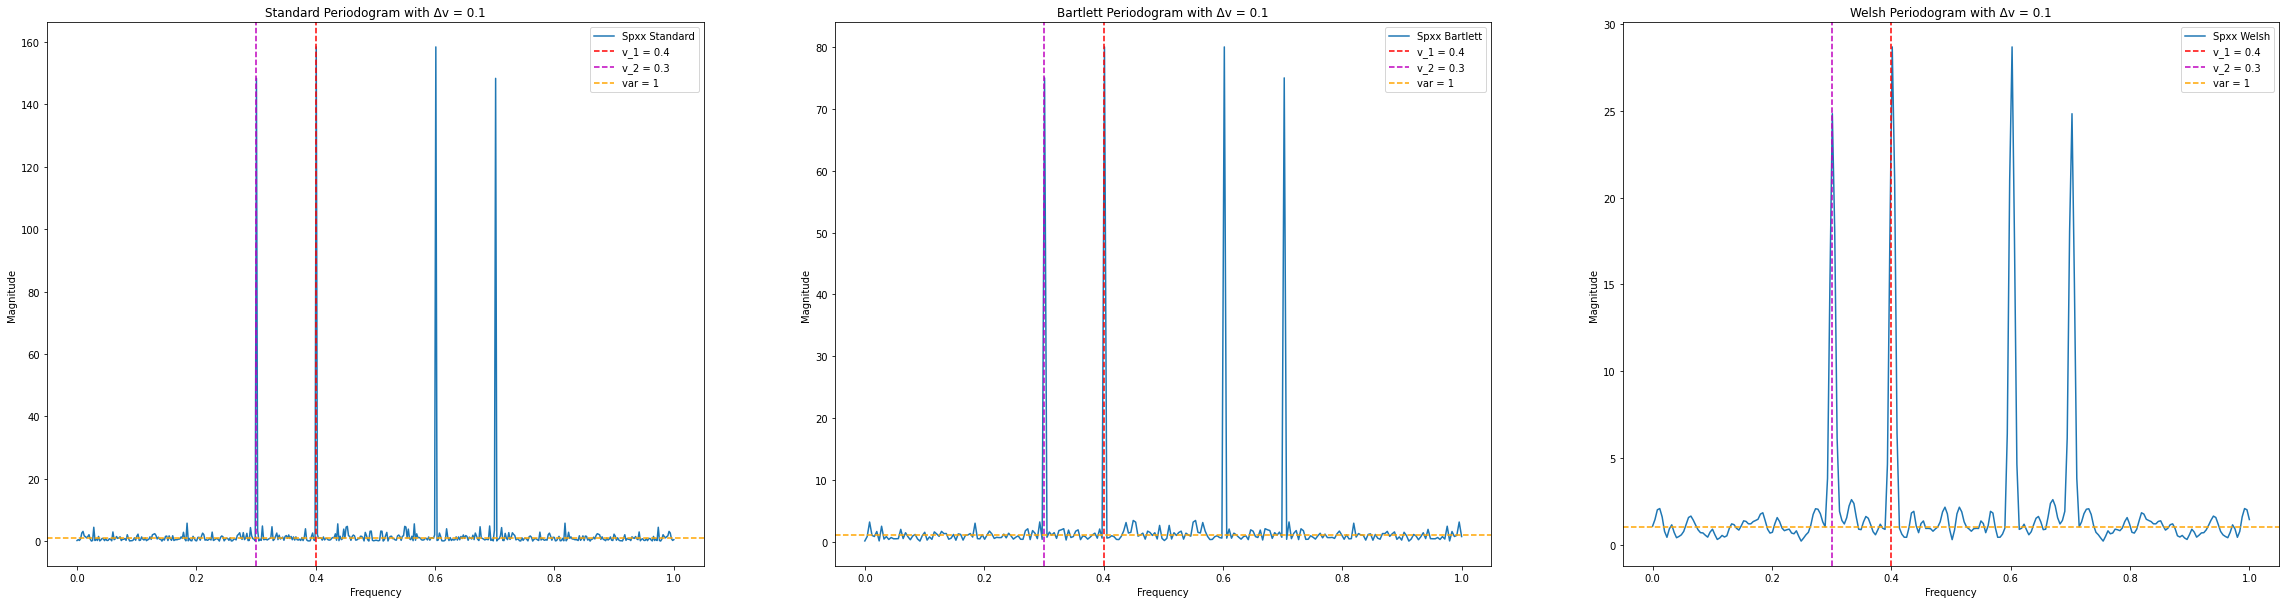

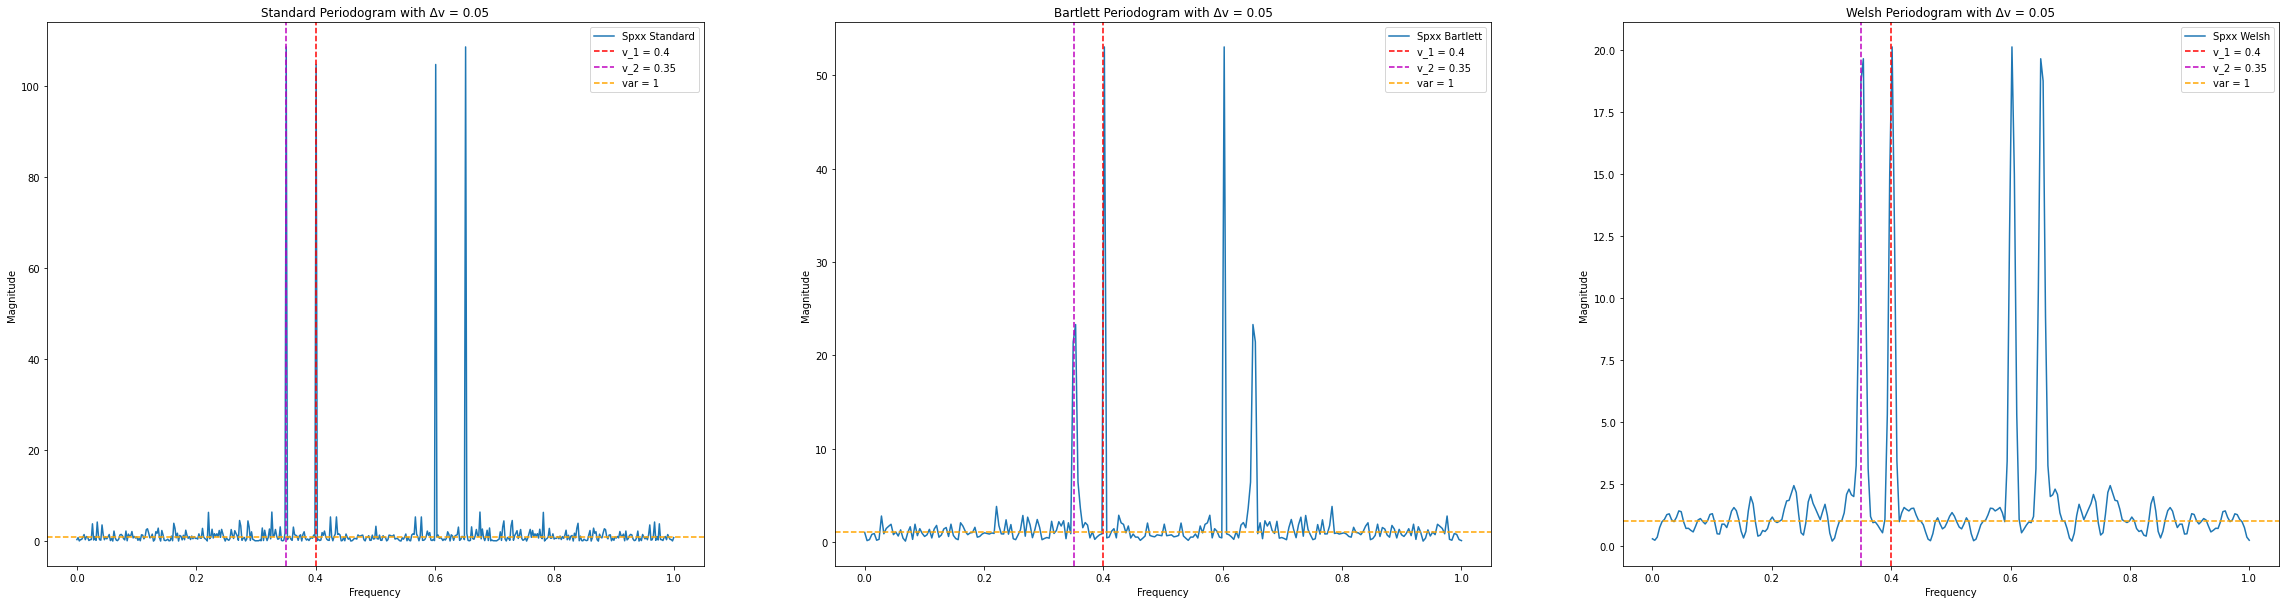

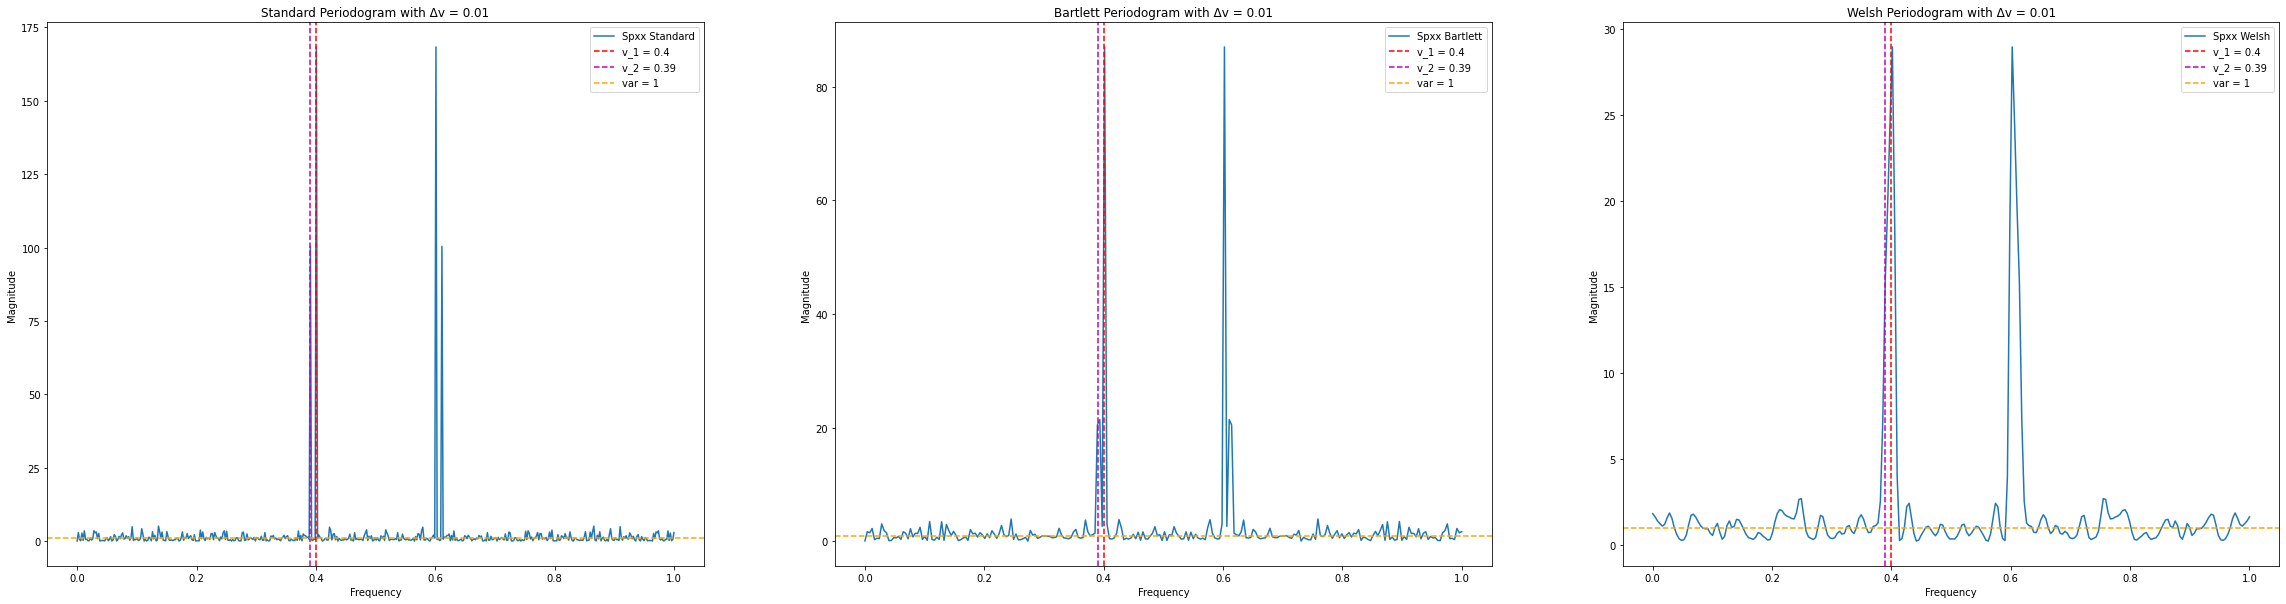

In [ ]:
for i in range(len(v2)):
  Spxx = Periodogram(Xt_vect[i],'Standard')
  Spxx_B = Periodogram(Xt_vect[i], 'Bartlett', M = 250)
  Spxx_W = Periodogram(Xt_vect[i], 'Welsh', M = 250)

  fig, axs = plt.subplots(1, 3,figsize=(40,10))
  axs[0].plot(np.linspace(0,1,len(Spxx)), Spxx, label = 'Spxx Standard')
  axs[0].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[0].axvline(v2[i], color='m', ls='--',label=f'v_2 = {v2[i]}')
  axs[0].axhline(var, color='orange', ls='--',label = f'var = {var}')
  axs[0].set_ylabel('Magnitude')
  axs[0].set_xlabel('Frequency')
  axs[0].legend()
  axs[0].set_title(f'Standard Periodogram with Δv = {round(delta[i],3)}')
  axs[1].plot(np.linspace(0,1,len(Spxx_B)), Spxx_B, label = 'Spxx Bartlett')
  axs[1].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[1].axvline(v2[i], color='m', ls='--',label=f'v_2 = {v2[i]}')
  axs[1].axhline(var, color='orange', ls='--',label = f'var = {var}')
  axs[1].set_ylabel('Magnitude')
  axs[1].set_xlabel('Frequency')
  axs[1].legend()
  axs[1].set_title(f'Bartlett Periodogram with Δv = {round(delta[i],3)}')
  axs[2].plot(np.linspace(0,1,len(Spxx_W)), Spxx_W, label = 'Spxx Welsh')
  axs[2].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[2].axvline(v2[i], color='m', ls='--',label=f'v_2 = {v2[i]}')
  axs[2].axhline(var, color='orange', ls='--',label = f'var = {var}')
  axs[2].set_ylabel('Magnitude')
  axs[2].set_xlabel('Frequency')
  axs[2].legend()
  axs[2].set_title(f'Welsh Periodogram with Δv = {round(delta[i],3)}')
  plt.show()


By analyzing the figure, we can conclude that the resolution of the standard periodogram is the best among the methods. This becomes noticeable when we set $Δν = 0.01$  and the standard method allows the sinusoid frequency peaks to be differentiated. On the other hand, for the same small $Δν$, the Welsh method merges the two peaks, making it impossible to identify that there are two peaks at different frequencies. Finally, it is worth mentioning that the merging of the two peaks occurs in the Bartlett method, but it is partial and it is possible to identify that there are two peaks at different frequencies.

We can calculate the $SNR$ (Signal-to-noise-ratio) as:

$$SNR_{dB} = \frac{\frac{1}{T}\sum_{t=1}^T signal^2}{σ^2} $$

where $μ$ is the mean of the signal and $σ^2$ is the variance of the noise. So, we can analyze the efficiency of each periodogram methods by varying the SNR (changing the value of the variance).


In [ ]:
#function to synthesize a sum of sinusoids and return the SNR

def SinusoidsSNR(N, K, freq, amp, phases, var):
  Xt = np.zeros(N)
  Zt = np.random.normal(0, var, size = N)
  for t in range(1,N):
    aux = 0 
    for j in range(K):
      aux += amp[j]*np.sin(2*np.pi*freq[j]*t + phases[j])
    Xt[t] =  aux
  SNR = 10*np.log10((1/len(Xt))*np.sum(Xt**2)/var)
  Xt = Xt + Zt
  return Xt, SNR

In [ ]:
var_vect = [1,2.5]
N = 500
K = 2
amp = [1, 1]
phases = [0, 0]
var = 1
v1 = 0.4
v2 = 0.2
freq = [v1,v2]

Xt_vect = []
SNR = []
for i in range(len(var_vect)):
  Xt, SNR_i = SinusoidsSNR(N, K, freq, amp, phases, var_vect[i])
  Xt_vect.append(Xt)
  SNR.append(SNR_i)

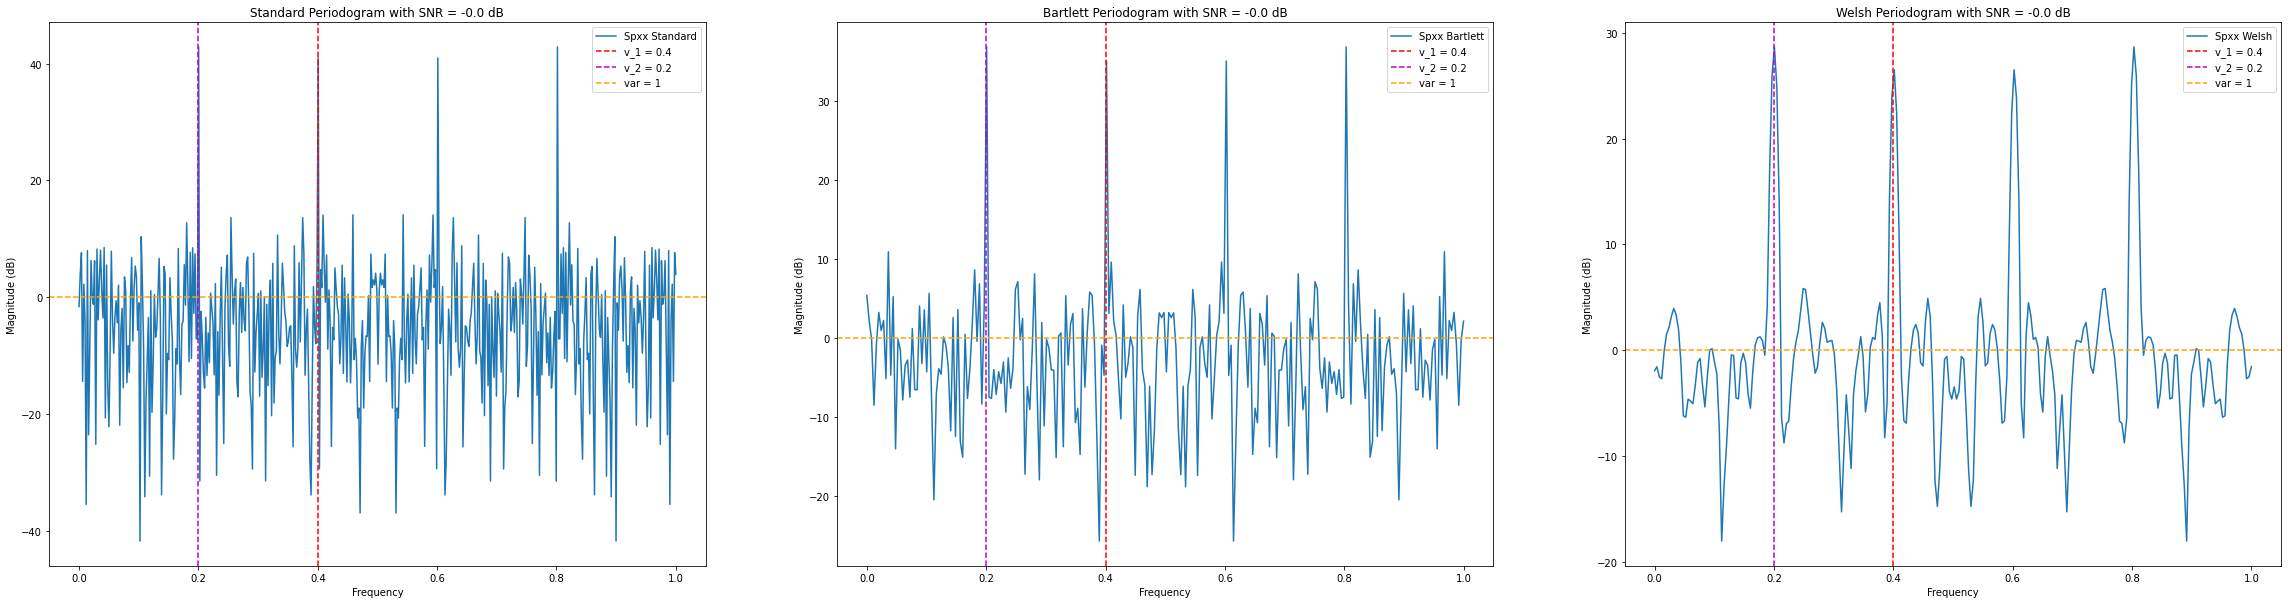

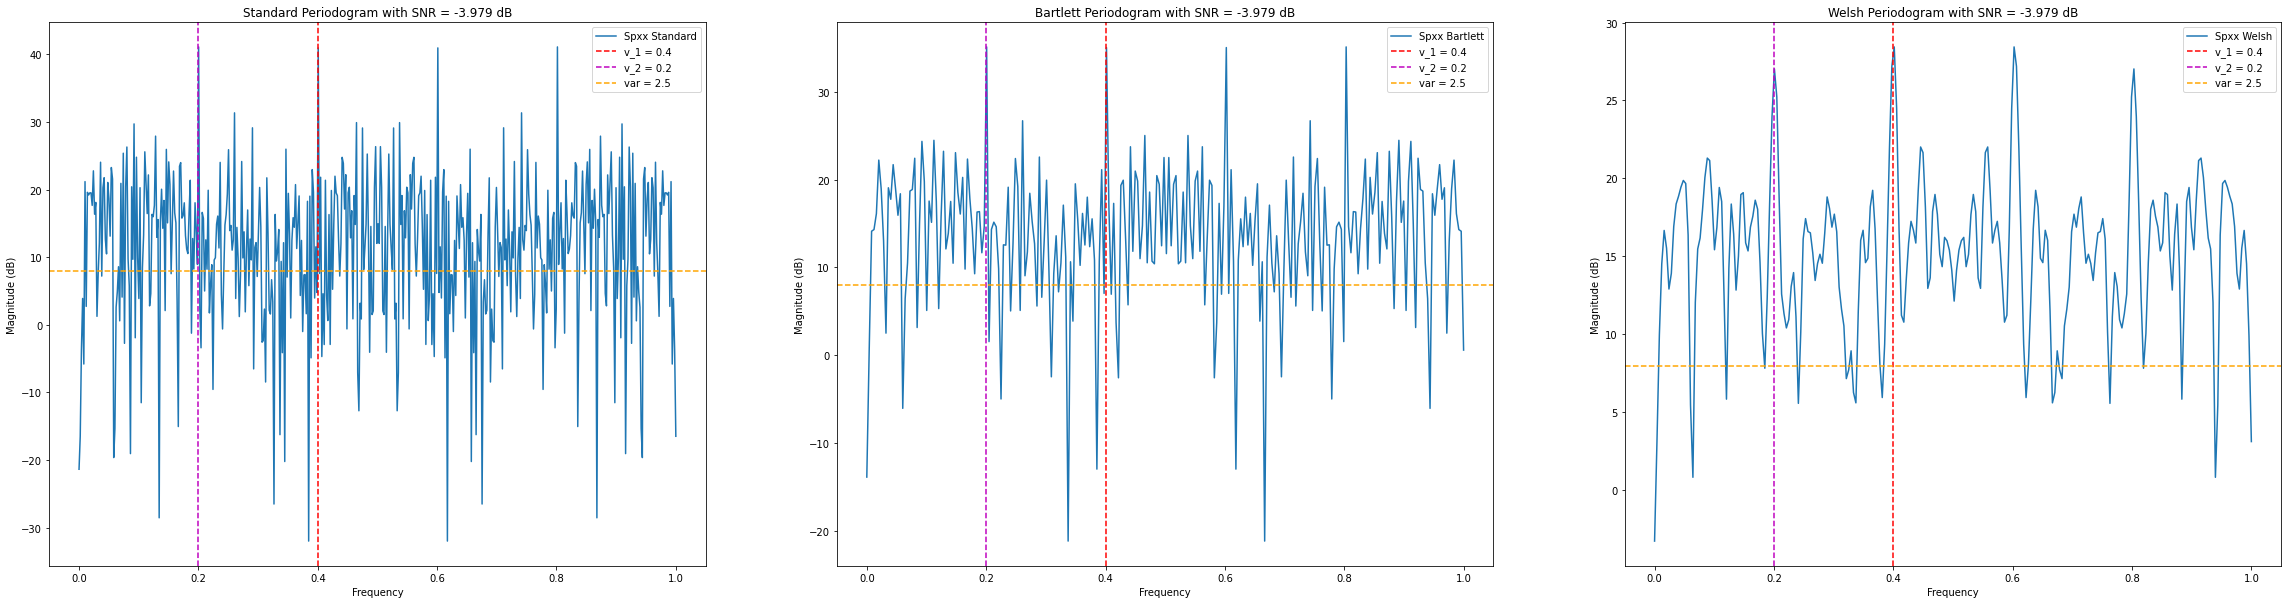

In [ ]:
for i in range(len(var_vect)):
  Spxx = Periodogram(Xt_vect[i],'Standard')
  Spxx_B = Periodogram(Xt_vect[i], 'Bartlett', M = 250)
  Spxx_W = Periodogram(Xt_vect[i], 'Welsh', M = 250)

  fig, axs = plt.subplots(1, 3,figsize=(40,10))
  axs[0].plot(np.linspace(0,1,len(Spxx)), 20*np.log10(Spxx), label = 'Spxx Standard')
  axs[0].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[0].axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
  axs[0].axhline(20*np.log10(var_vect[i]), color='orange', ls='--',label = f'var = {var_vect[i]}')
  axs[0].set_ylabel('Magnitude (dB)')
  axs[0].set_xlabel('Frequency')
  axs[0].legend()
  axs[0].set_title(f'Standard Periodogram with SNR = {round(SNR[i],3)} dB')
  axs[1].plot(np.linspace(0,1,len(Spxx_B)), 20*np.log10(Spxx_B), label = 'Spxx Bartlett')
  axs[1].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[1].axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
  axs[1].axhline(20*np.log10(var_vect[i]), color='orange', ls='--',label = f'var = {var_vect[i]}')
  axs[1].set_ylabel('Magnitude (dB)')
  axs[1].set_xlabel('Frequency')
  axs[1].legend()
  axs[1].set_title(f'Bartlett Periodogram with SNR = {round(SNR[i],3)} dB')
  axs[2].plot(np.linspace(0,1,len(Spxx_W)), 20*np.log10(Spxx_W), label = 'Spxx Welsh')
  axs[2].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[2].axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
  axs[2].axhline(20*np.log10(var_vect[i]), color='orange', ls='--',label = f'var = {var_vect[i]}')
  axs[2].set_ylabel('Magnitude (dB)')
  axs[2].set_xlabel('Frequency')
  axs[2].legend()
  axs[2].set_title(f'Welsh Periodogram with SNR = {round(SNR[i],3)} dB')
  plt.show()

Regarding the SNR variation, we can see that for all methods it becomes much more complicated to identify the fundamental frequencies of the sinusoids. However, it can be said that the periodogram is the method in which it is most difficult to identify the peaks in the fundamental frequencies, due to its high variance. On the other hand, for $SNR = -3.979 \; dB$, it is possible to realize that using the Welsh method we can identify two peaks at the fundamental frequencies.


### **2.3 Parametric estimation: linear prediction**

In [ ]:
#Function to calculate the psd of any AR model

def PSD(var, a_coeff, N): 
    p = len(a_coeff)
    freq = np.linspace(0,1,N)
    aux = [(a_coeff[k-1])*np.exp(-2*1j*np.pi*freq*k) for k in np.arange(1, p+1)]
    psd = var/(np.abs(1-np.sum(aux, axis=0))**2)
    return psd

We can analyze the linear prediction method by varying $Δν$.


In [ ]:
N = 500
K = 2
amp = [1, 1]
phases = [0, 0]
var = 1
v1 = 0.4
v2 = [0.1, 0.2, 0.3, 0.39]
Xt_vect = []
delta = []
for i in range(len(v2)):
  freq = [v1,v2[i]]
  delta.append(np.abs(v1 - v2[i]))
  Xt_vect.append(Sinusoids(N, K, freq, amp, phases, var))

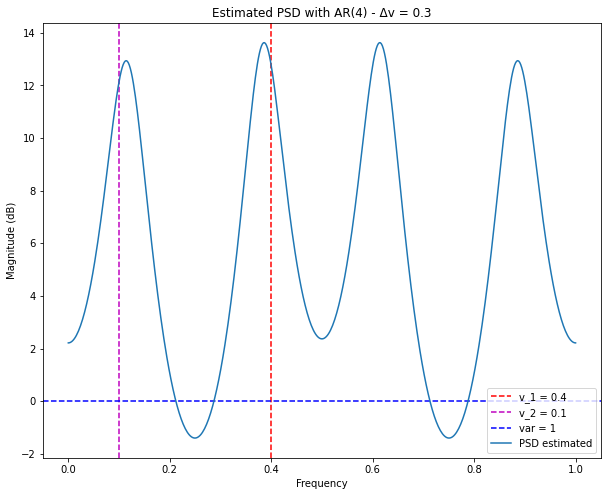

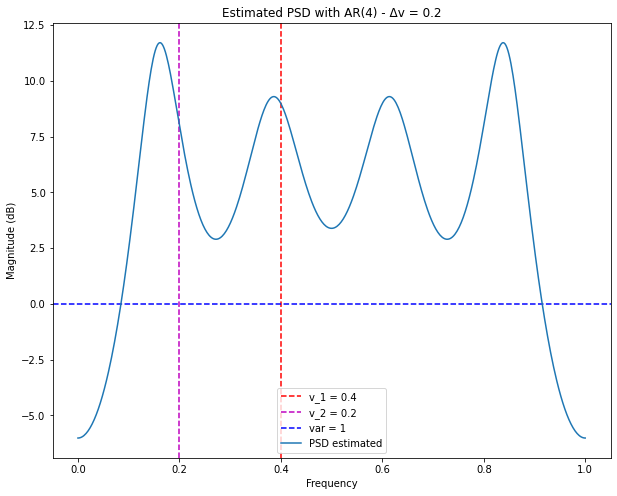

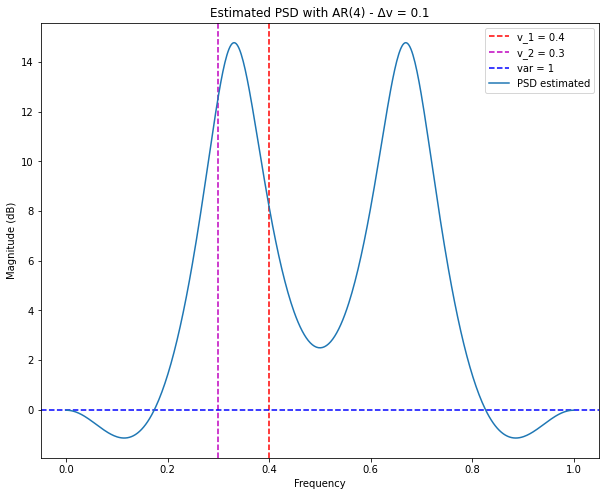

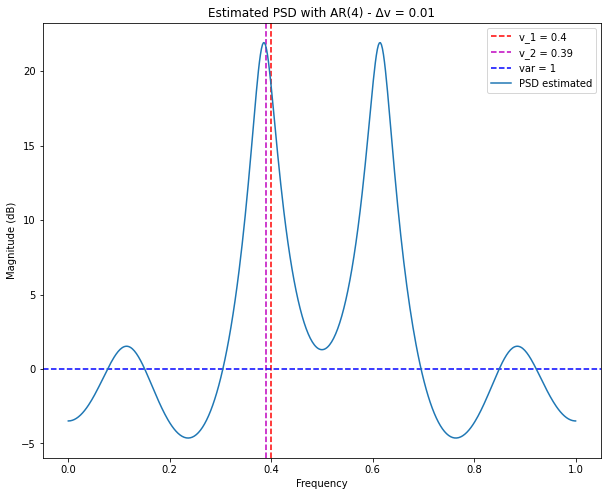

In [ ]:
for i in range(len(v2)):

  #estimating the model with AR(4)
  estimated_coeff, sigma2Est = estimateAr(Xt_vect[i], 4)
  psd = PSD(sigma2Est,-estimated_coeff[1:],N)

  #plotting
  plt.figure(figsize = (10,8))
  plt.axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  plt.axvline(v2[i], color='m', ls='--',label=f'v_2 = {v2[i]}')
  plt.axhline(20*np.log10(var), color='b', ls='--',label = f'var = {var}')
  plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD estimated')
  plt.plot()
  plt.ylabel('Magnitude (dB)')
  plt.xlabel('Frequency')
  plt.title(f'Estimated PSD with AR(4) - Δv = {round(delta[i],3)}')
  plt.legend()
  plt.show()

As the $\Delta \nu$ gets smaller the spectral resolution using the AR(4) model approximation gets worse. For example, when $\Delta \nu = 0.1$ , the peaks at the fundamental frequencies of the sinusoids become indistinguishable, merged. So, we can conclude that this is not 

We can also analyze the linear prediction method by varying $SNR$ as we did in the previous section of this notebook.

In [ ]:
var_vect = [1,2.5,5,10]
N = 500
K = 2
amp = [1, 1]
phases = [0, 0]
var = 1
v1 = 0.4
v2 = 0.2
freq = [v1,v2]

Xt_vect = []
SNR = []
for i in range(len(var_vect)):
  Xt, SNR_i = SinusoidsSNR(N, K, freq, amp, phases, var_vect[i])
  Xt_vect.append(Xt)
  SNR.append(SNR_i)

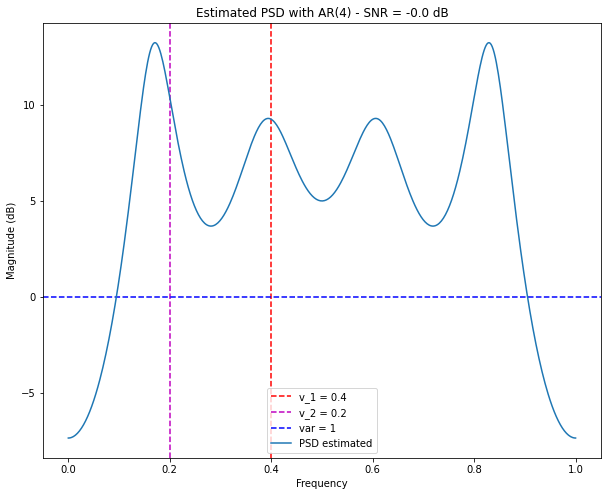

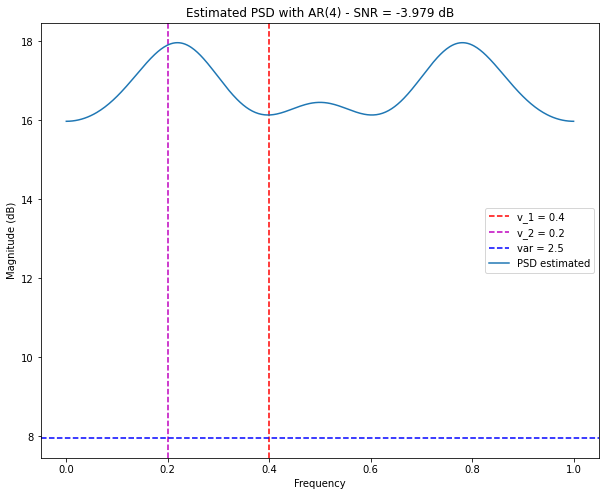

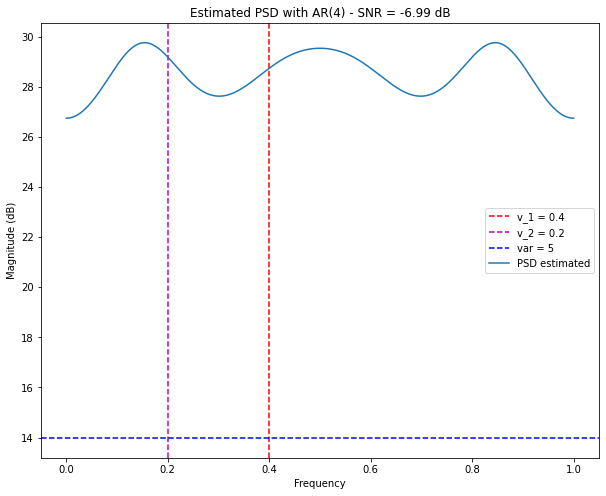

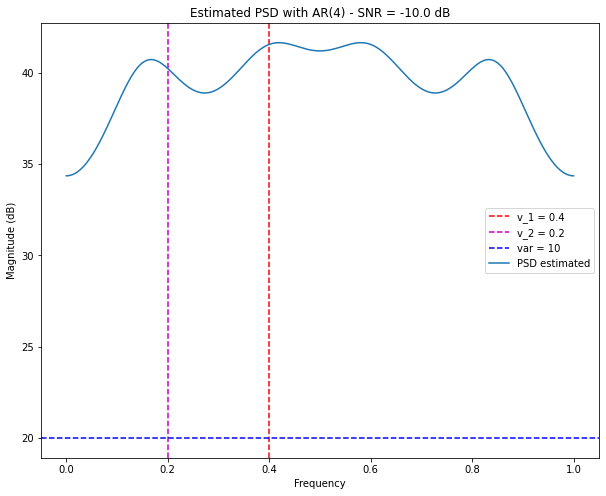

In [ ]:
for i in range(len(var_vect)):

  #estimating the model with AR(4)
  estimated_coeff, sigma2Est = estimateAr(Xt_vect[i], 4)
  psd = PSD(sigma2Est,-estimated_coeff[1:],N)

  #plotting
  plt.figure(figsize = (10,8))
  plt.axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  plt.axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
  plt.axhline(20*np.log10(var_vect[i]), color='b', ls='--',label = f'var = {var_vect[i]}')
  plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD estimated')
  plt.plot()
  plt.ylabel('Magnitude (dB)')
  plt.xlabel('Frequency')
  plt.title(f'Estimated PSD with AR(4) - SNR = {round(SNR[i],3)} dB')
  plt.legend()
  plt.show()

As the SNR decreases, the estimation performed with AR(4) becomes worse. That is, it becomes difficult to identify the fundamental frequencies of the sinusoids that make up the signal. However, compared to the other methods discussed in the previous section, the approximation by an AR(4) model allowed to identify the fundamental frequencies in signals with higher SNR. Up to $SNR = -6.99 \;dB$, it is clear that we have two peaks at fundamental frequencies. However, for $SNR = -10 \;dB$, it becomes really difficult to identify.

### **2.4 Parametric estimation: Capon estimator**

To define the capon estimator, we need to compute the estimated covariance matrix:

$$\hat R = \frac{1}{N-M} \sum_{t=M+1}^{N} X_M X^H_M$$

where $X_M = [X_t \; X_{t-1} \; ... \; X_{t-M} ]^T$. The we will define the following basis:

$$ e(\nu) = [1, \ e^{-2 \pi i \nu}, \ ..., \ e^{-2 \pi i \nu M} ]^T $$

So, finally the capon estimator is given by:

$$\hat S_{CAP}(\nu) = \frac{M+1}{e^H(\nu) \hat R^{-1} e(\nu) }$$

[[Stoica - Spectral Analysis of Signal](http://user.it.uu.se/~ps/SAS-new.pdf)]

In [ ]:
#Function to estimate the covariance matrix
def covMatrixEst(Xt, M, N):
  Rhat = np.zeros((M+1,M+1))
  for i in np.arange(M, N):
    Rhat = Rhat  +  np.outer(Xt[i - M: i+1], np.conjugate(Xt[i - M: i+1]))
  Rhat = Rhat/(N - M)
  return Rhat

#Function to return the exponential basis 
def e(f,M):
  basis = np.array([np.exp(-2*np.pi*1j*f*k)for k in np.arange(0, M+1)])
  return basis

#Function to estimate the PSD using the Capon estimator 
def CaponMethod(Xt, M, N):
  Scapon = np.zeros(N)
  freq = np.linspace(0,1,N)
  Rhat = covMatrixEst(Xt,M,N)
  for i in np.arange(0, N):
        Scapon[i] = 1/np.dot(np.conjugate(e(freq[i], M)).T, np.dot(np.linalg.inv(Rhat), e(freq[i], M)))
  Scapon = Scapon*(M+1)
  return Scapon

We are going to first compare the Capon Estimator with the Bartlett and Welsh methods, by varying $\Delta ν$, as well as the SNR.

In [ ]:
N = 500
K = 2
amp = [1, 1]
phases = [0, 0]
var = 1
v1 = 0.4
v2 = [0.2, 0.3, 0.35, 0.39]
Xt_vect = []
delta = []

for i in range(len(v2)):
  freq = [v1,v2[i]]
  delta.append(np.abs(v1 - v2[i]))
  Xt_vect.append(Sinusoids(N, K, freq, amp, phases, var))

Spcap = []
Spxx_B = []
Spxx_W = []
for i in range(len(v2)):
  Spcap.append(CaponMethod(Xt_vect[i], 100, 500))
  Spxx_B.append(Periodogram(Xt_vect[i], 'Bartlett', M = 250))
  Spxx_W.append(Periodogram(Xt_vect[i], 'Welsh', M = 250))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


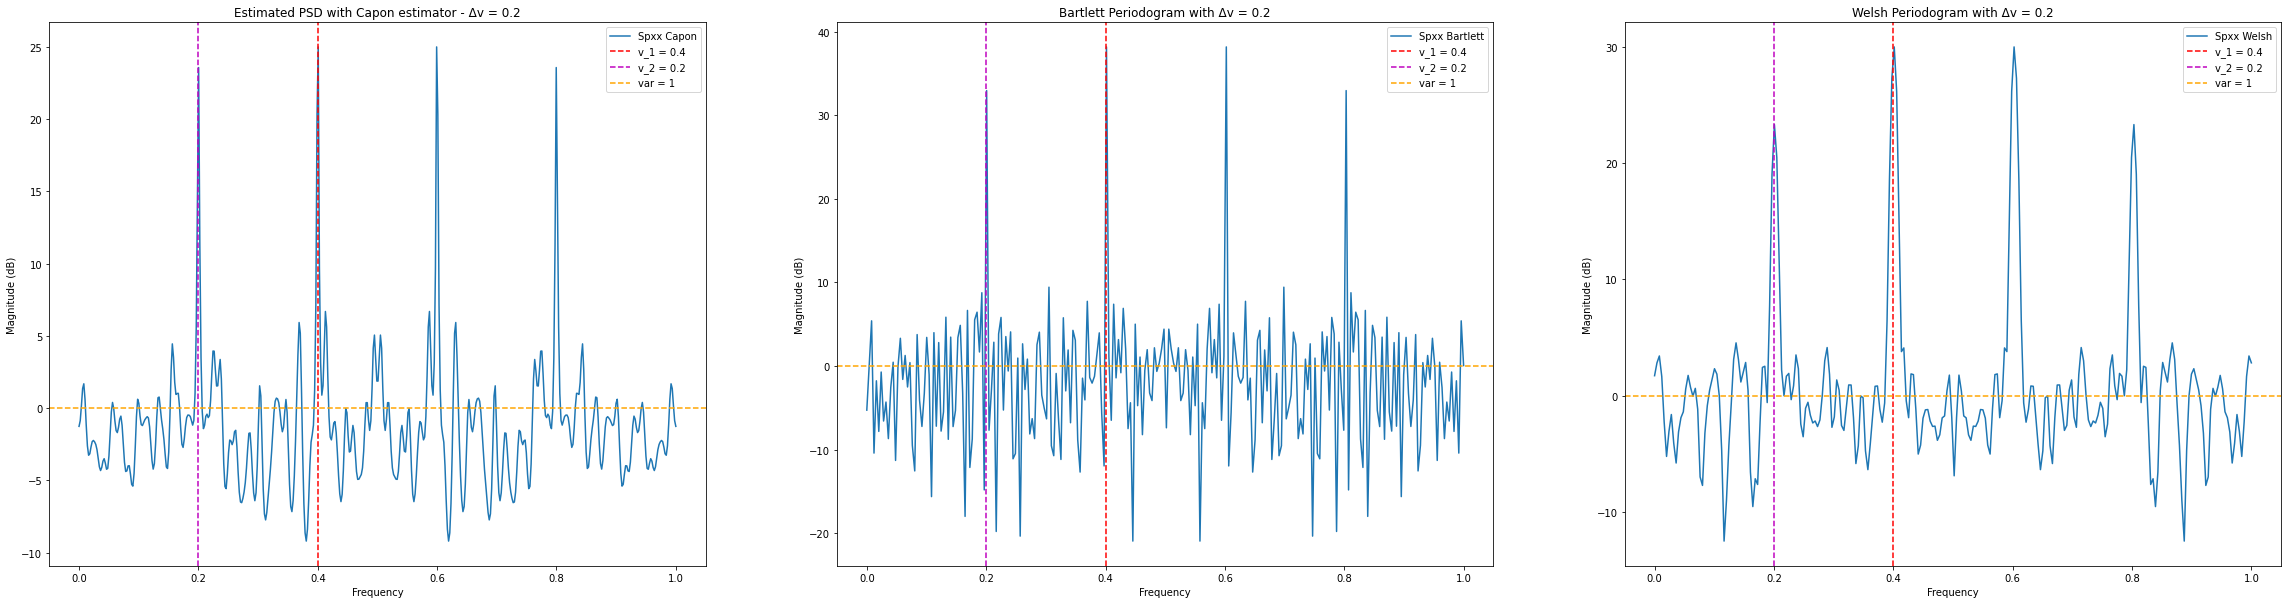

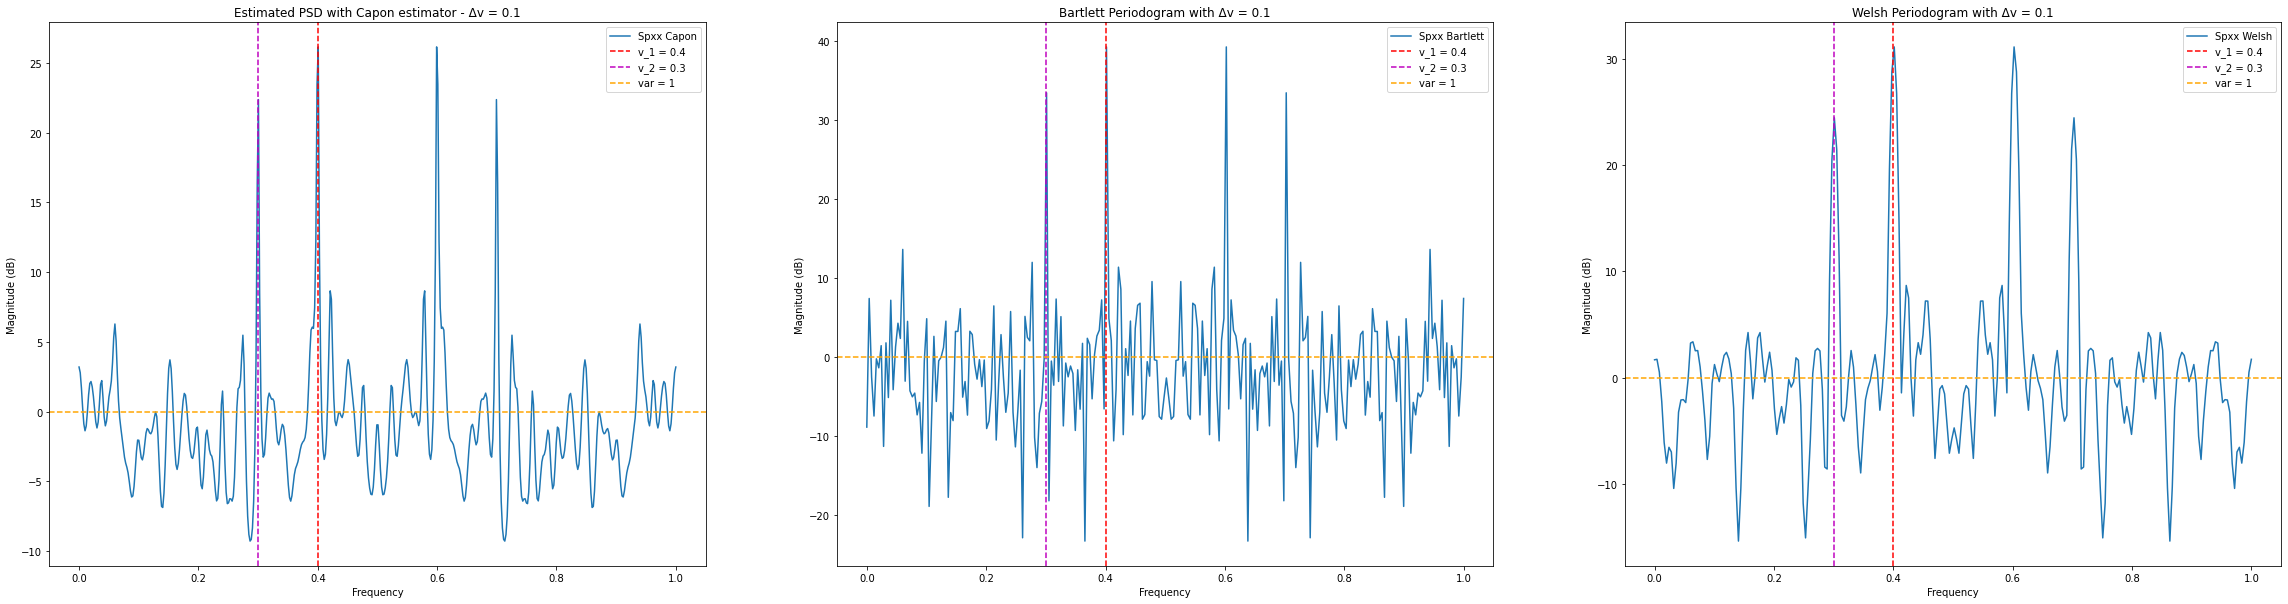

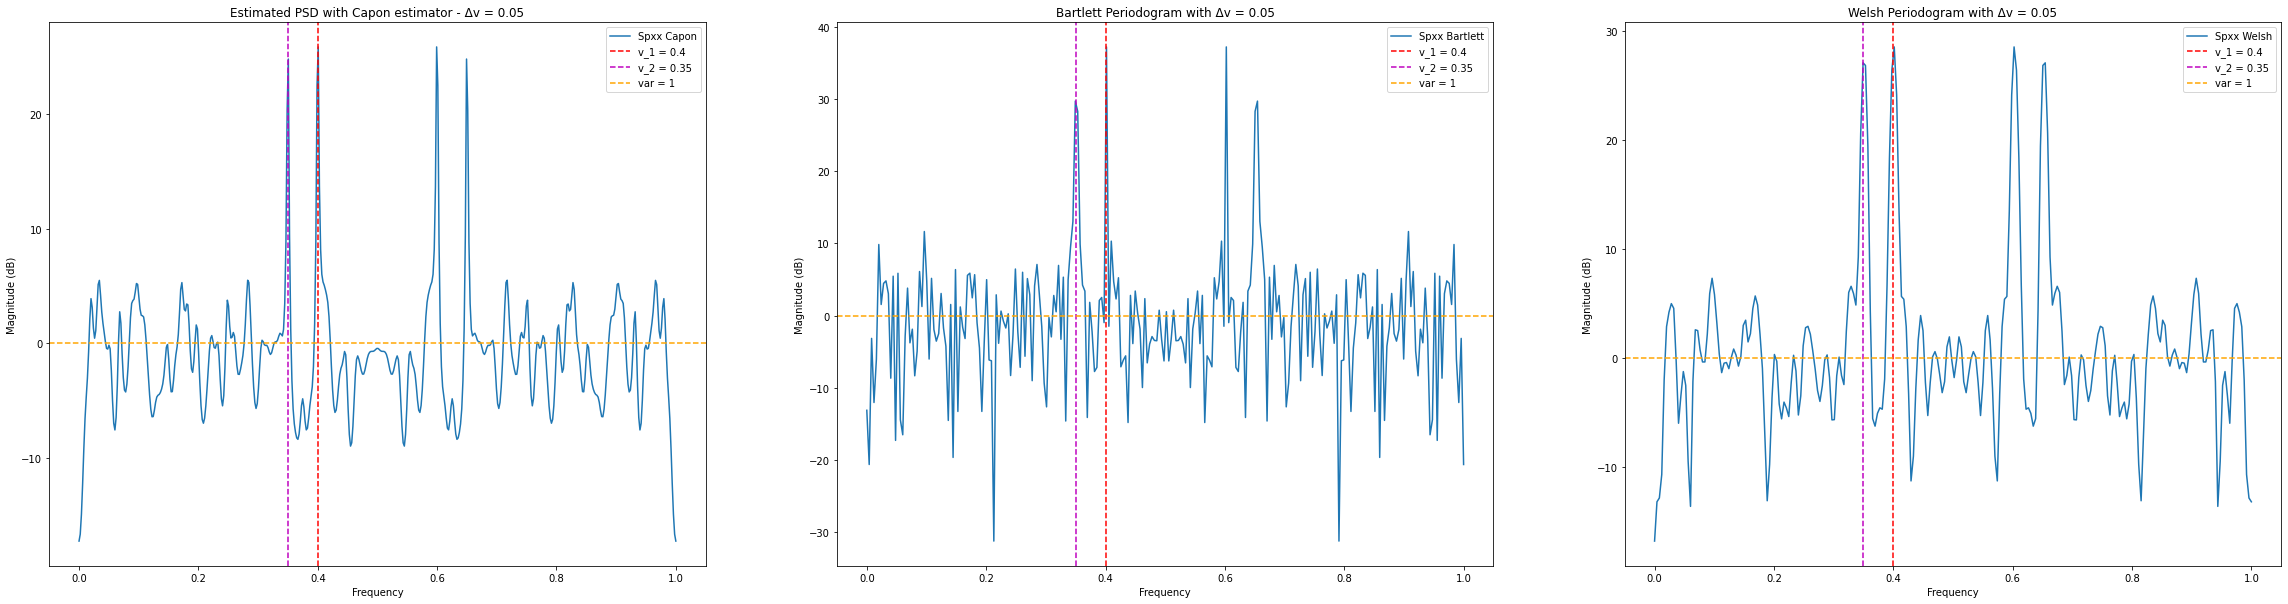

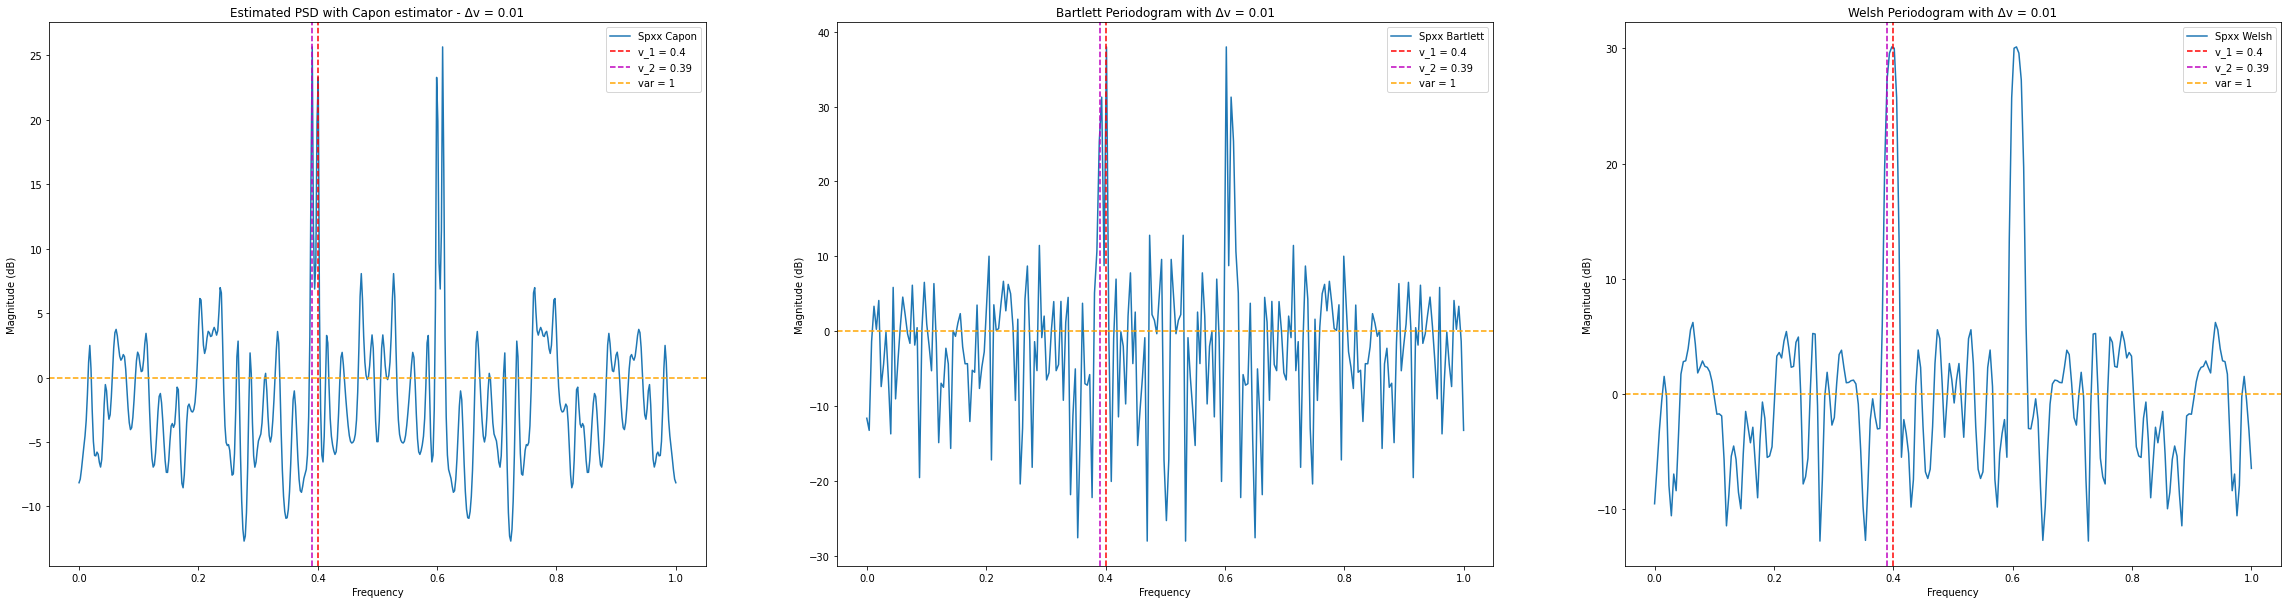

In [ ]:
for i in range(len(v2)):
  fig, axs = plt.subplots(1, 3,figsize=(40,10))
  axs[0].plot(np.linspace(0,1,len(Spcap[i])), 20*np.log10(Spcap[i]), label = 'Spxx Capon')
  axs[0].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[0].axvline(v2[i], color='m', ls='--',label=f'v_2 = {v2[i]}')
  axs[0].axhline(20*np.log10(var), color='orange', ls='--',label = f'var = {var}')
  axs[0].set_ylabel('Magnitude (dB)')
  axs[0].set_xlabel('Frequency')
  axs[0].legend()
  axs[0].set_title(f'Estimated PSD with Capon estimator - Δv = {round(delta[i],3)}')
  axs[1].plot(np.linspace(0,1,len(Spxx_B[i])), 20*np.log10(Spxx_B[i]), label = 'Spxx Bartlett')
  axs[1].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[1].axvline(v2[i], color='m', ls='--',label=f'v_2 = {v2[i]}')
  axs[1].axhline(20*np.log10(var), color='orange', ls='--',label = f'var = {var}')
  axs[1].set_ylabel('Magnitude (dB)')
  axs[1].set_xlabel('Frequency')
  axs[1].legend()
  axs[1].set_title(f'Bartlett Periodogram with Δv = {round(delta[i],3)}')
  axs[2].plot(np.linspace(0,1,len(Spxx_W[i])), 20*np.log10(Spxx_W[i]), label = 'Spxx Welsh')
  axs[2].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[2].axvline(v2[i], color='m', ls='--',label=f'v_2 = {v2[i]}')
  axs[2].axhline(20*np.log10(var), color='orange', ls='--',label = f'var = {var}')
  axs[2].set_ylabel('Magnitude (dB)')
  axs[2].set_xlabel('Frequency')
  axs[2].legend()
  axs[2].set_title(f'Welsh Periodogram with Δv = {round(delta[i],3)}')
  plt.show()

The Capon estimator showed the best spectral resolution when compared to the other two methods. It can be seen that for the smallest $\Delta \nu$ (0.01),  the peaks are well defined, well distinguishable, at fundamental frequencies.

In [ ]:
var_vect = [1,2.5,5]
N = 500
K = 2
amp = [1, 1]
phases = [0, 0]
var = 1
v1 = 0.4
v2 = 0.2
freq = [v1,v2]

Xt_vect = []
SNR = []
for i in range(len(var_vect)):
  Xt, SNR_i = SinusoidsSNR(N, K, freq, amp, phases, var_vect[i])
  Xt_vect.append(Xt)
  SNR.append(SNR_i)

Spcap = []
Spxx_B = []
Spxx_W = []
for i in range(len(var_vect)):
  Spcap.append(CaponMethod(Xt_vect[i], 100, 500))
  Spxx_B.append(Periodogram(Xt_vect[i], 'Bartlett', M = 250))
  Spxx_W.append(Periodogram(Xt_vect[i], 'Welsh', M = 250))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


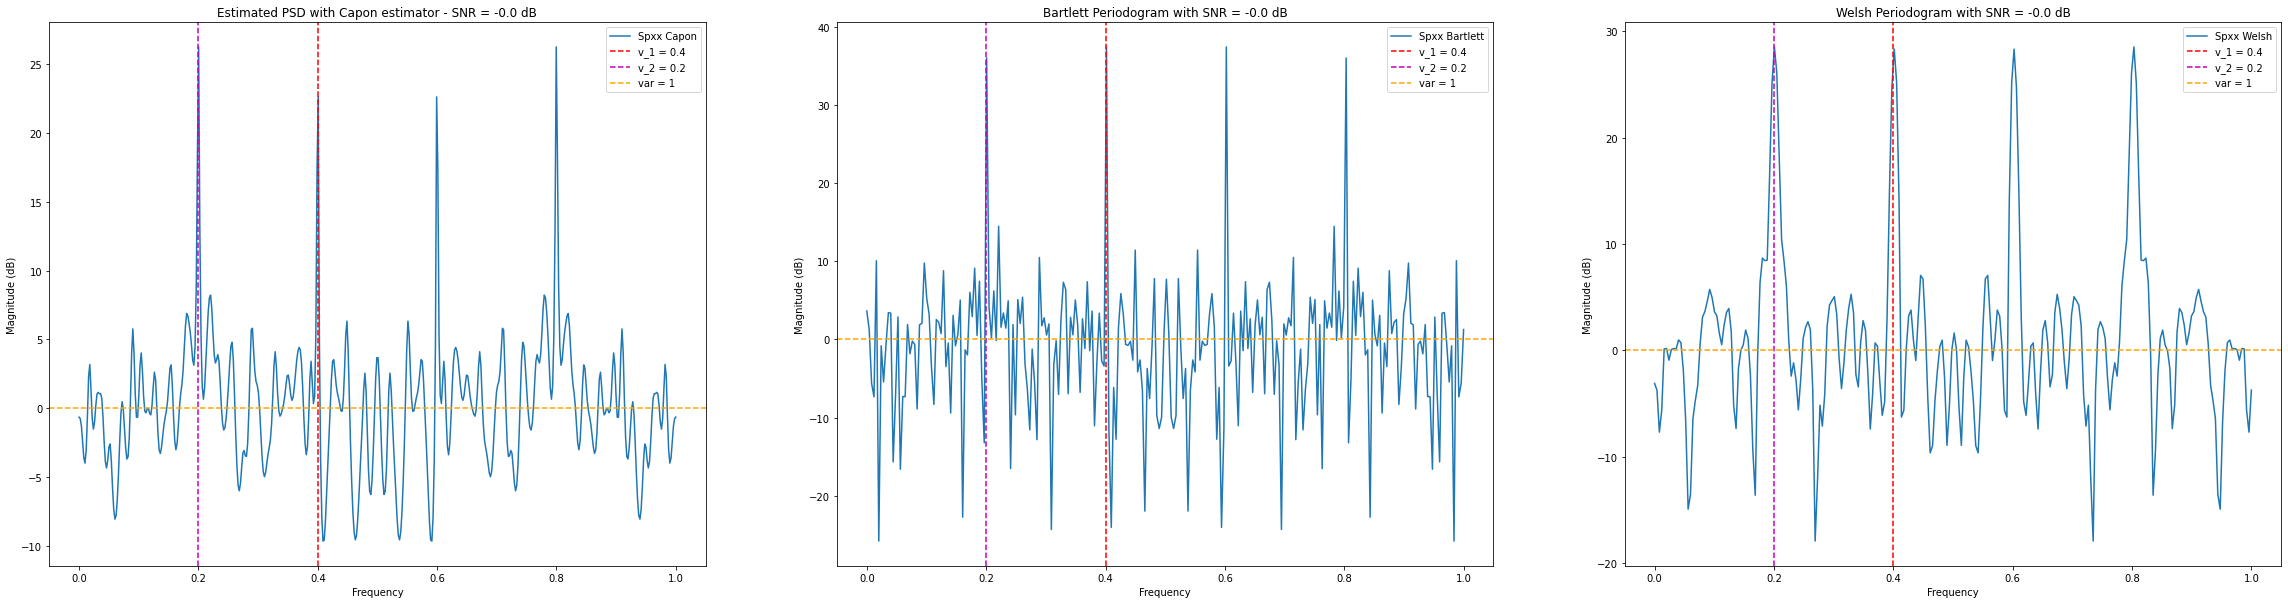

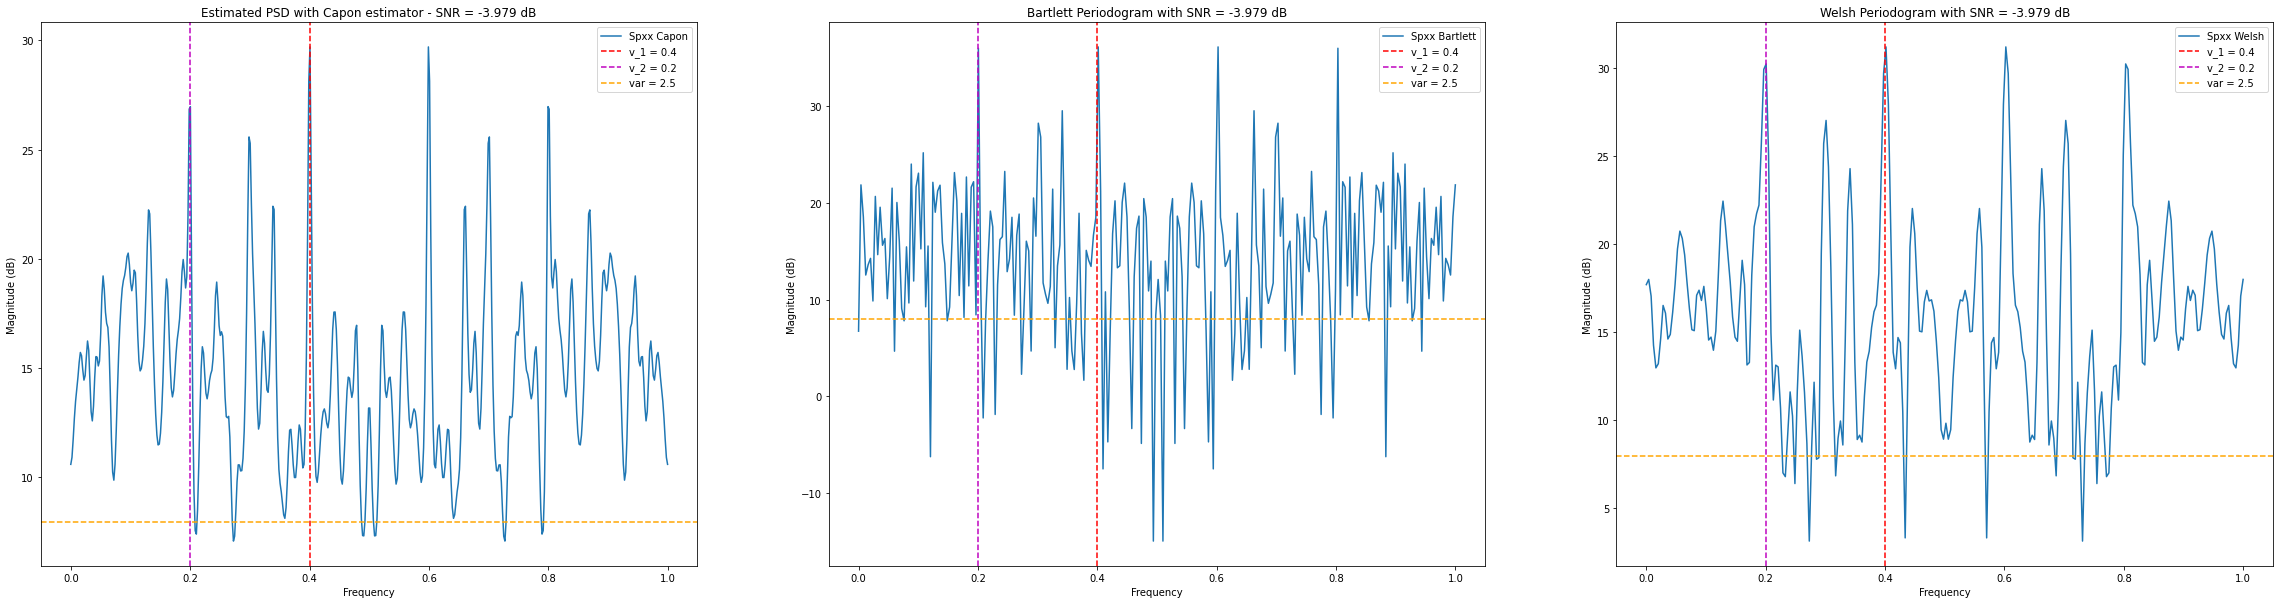

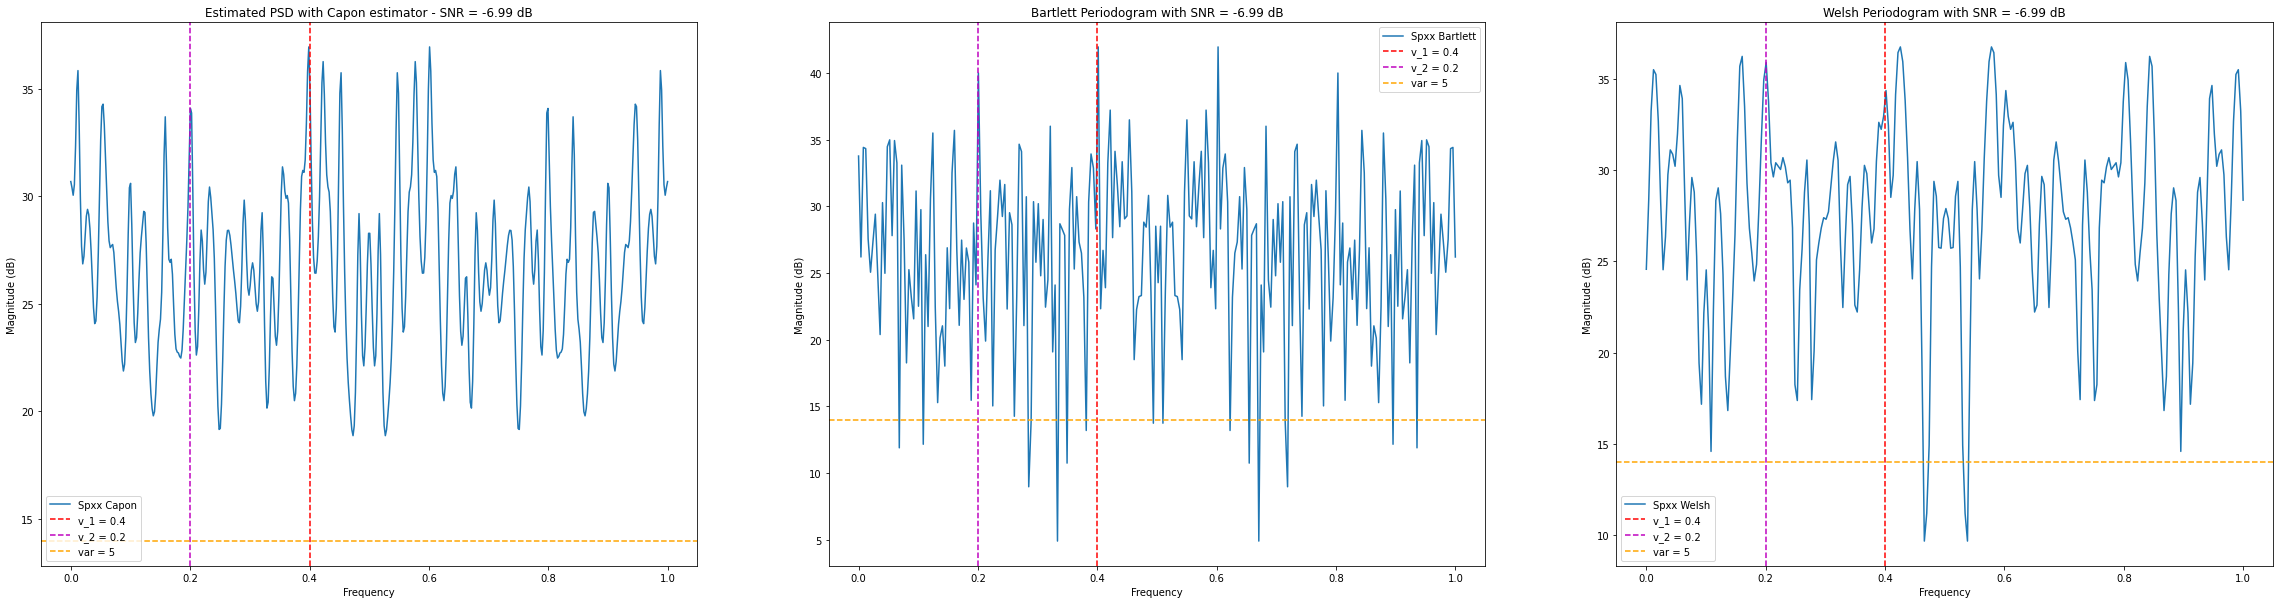

In [ ]:
for i in range(len(var_vect)):
  fig, axs = plt.subplots(1, 3,figsize=(40,10))
  axs[0].plot(np.linspace(0,1,len(Spcap[i])), 20*np.log10(Spcap[i]), label = 'Spxx Capon')
  axs[0].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[0].axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
  axs[0].axhline(20*np.log10(var_vect[i]), color='orange', ls='--',label = f'var = {var_vect[i]}')
  axs[0].set_ylabel('Magnitude (dB)')
  axs[0].set_xlabel('Frequency')
  axs[0].legend()
  axs[0].set_title(f'Estimated PSD with Capon estimator - SNR = {round(SNR[i],3)} dB')
  axs[1].plot(np.linspace(0,1,len(Spxx_B[i])), 20*np.log10(Spxx_B[i]), label = 'Spxx Bartlett')
  axs[1].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[1].axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
  axs[1].axhline(20*np.log10(var_vect[i]), color='orange', ls='--',label = f'var = {var_vect[i]}')
  axs[1].set_ylabel('Magnitude (dB)')
  axs[1].set_xlabel('Frequency')
  axs[1].legend()
  axs[1].set_title(f'Bartlett Periodogram with SNR = {round(SNR[i],3)} dB')
  axs[2].plot(np.linspace(0,1,len(Spxx_W[i])), 20*np.log10(Spxx_W[i]), label = 'Spxx Welsh')
  axs[2].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[2].axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
  axs[2].axhline(20*np.log10(var_vect[i]), color='orange', ls='--',label = f'var = {var_vect[i]}')
  axs[2].set_ylabel('Magnitude (dB)')
  axs[2].set_xlabel('Frequency')
  axs[2].legend()
  axs[2].set_title(f'Welsh Periodogram with SNR = {round(SNR[i],3)} dB')
  plt.show()

We can see that as the noise increases, the Capon estimator does not perform well. However, compared to the others, it gives a similar result to Welsh estimator, because for $SNR = -3.979 \; dB$, the peaks of the fundamental frequencies are identifiable.

So, we compare the Capon estimator with the linear prediction AR(4) model. We are going to do this also by varying $\Delta ν$ and SNR.

In [ ]:
N = 500
K = 2
amp = [1, 1]
phases = [0, 0]
var = 1
v1 = 0.4
v2 = [0.2, 0.3, 0.35, 0.39]
Xt_vect = []
delta = []

for i in range(len(v2)):
  freq = [v1,v2[i]]
  delta.append(np.abs(v1 - v2[i]))
  Xt_vect.append(Sinusoids(N, K, freq, amp, phases, var))

Spcap = []
psd = []
for i in range(len(v2)):
  Spcap.append(CaponMethod(Xt_vect[i], 100, 500))
  #estimating the model with AR(4)
  estimated_coeff, sigma2Est = estimateAr(Xt_vect[i], 4)
  psd.append(PSD(sigma2Est,-estimated_coeff[1:],N))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


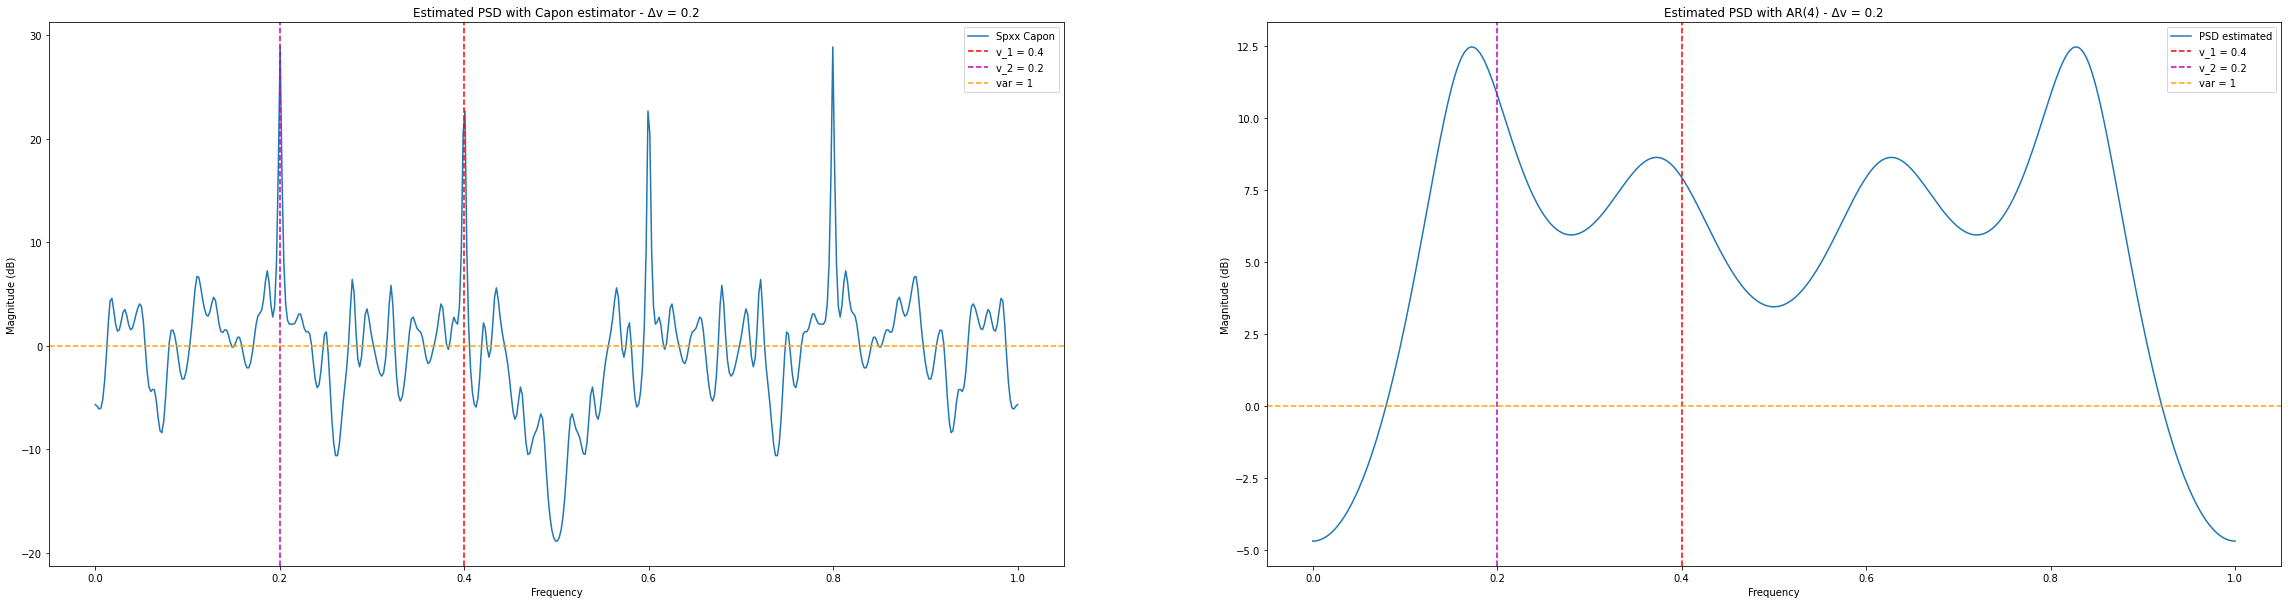

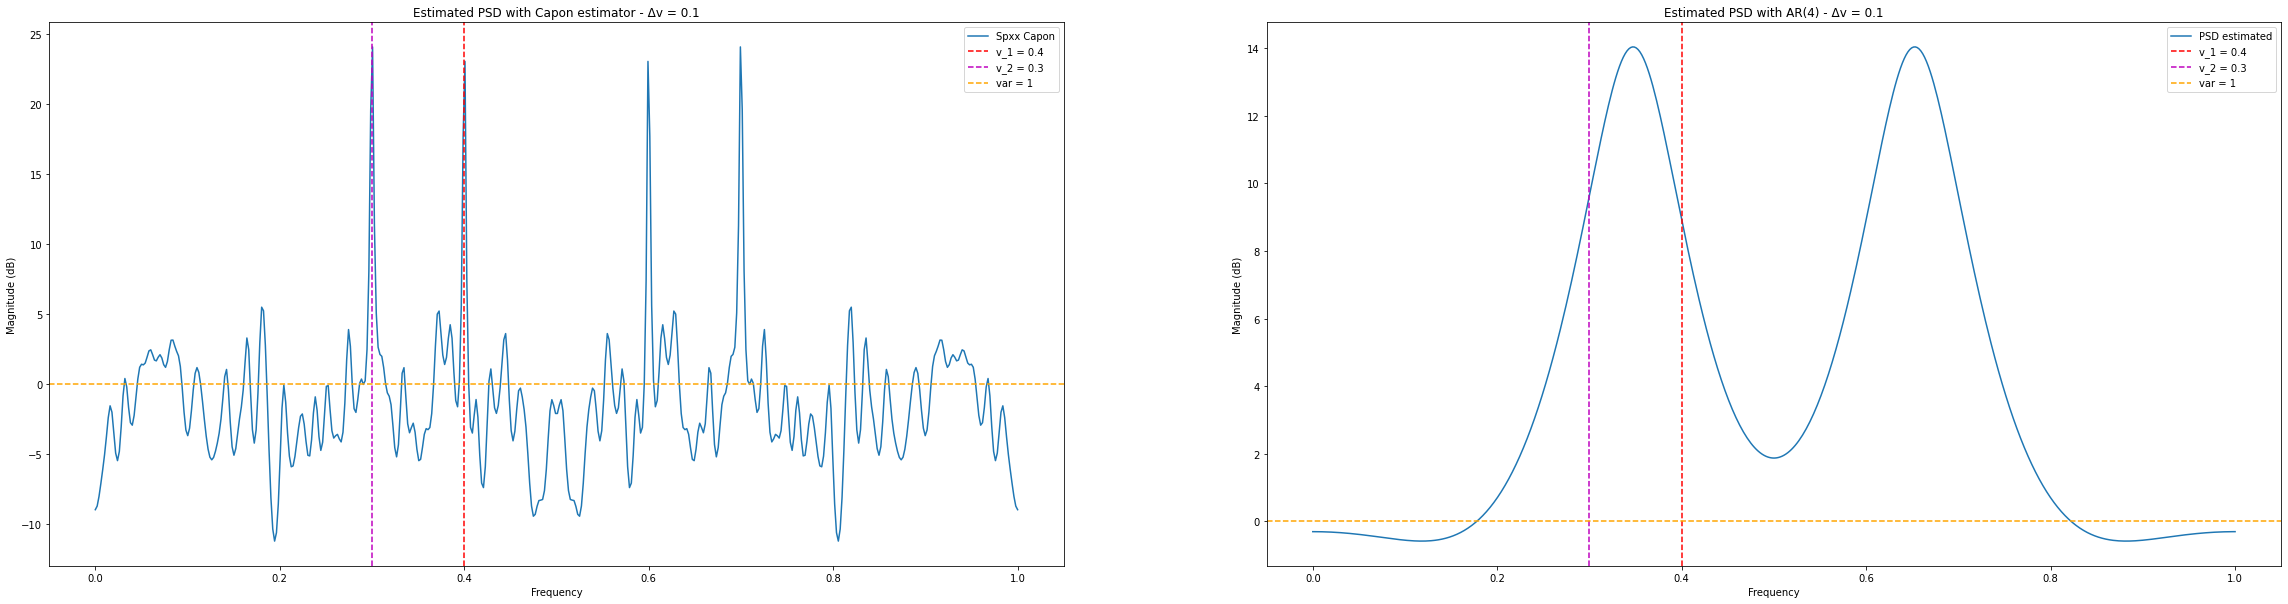

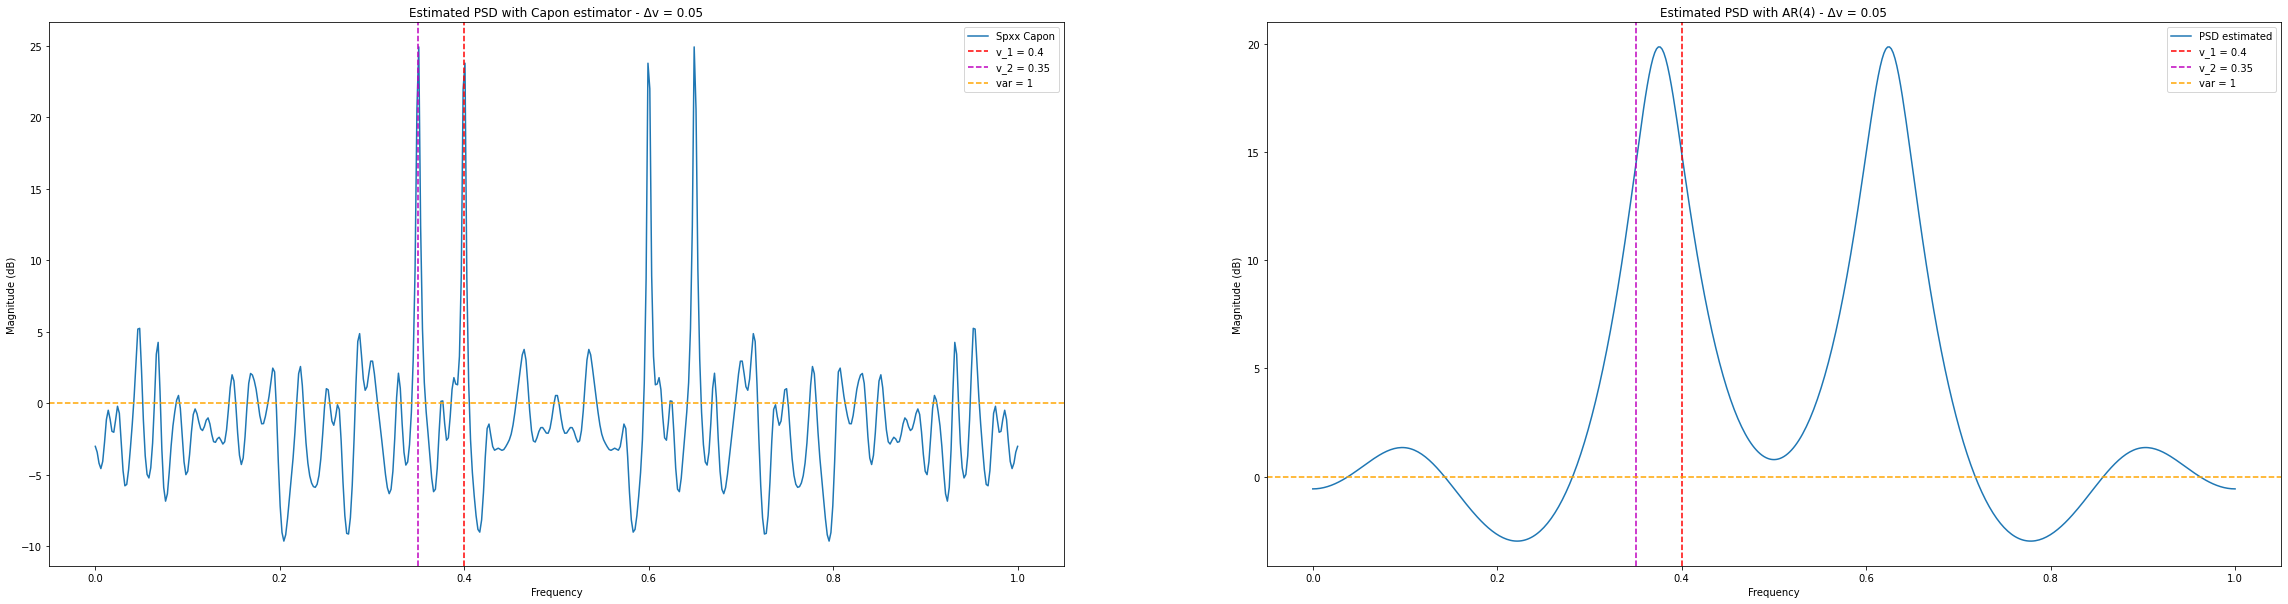

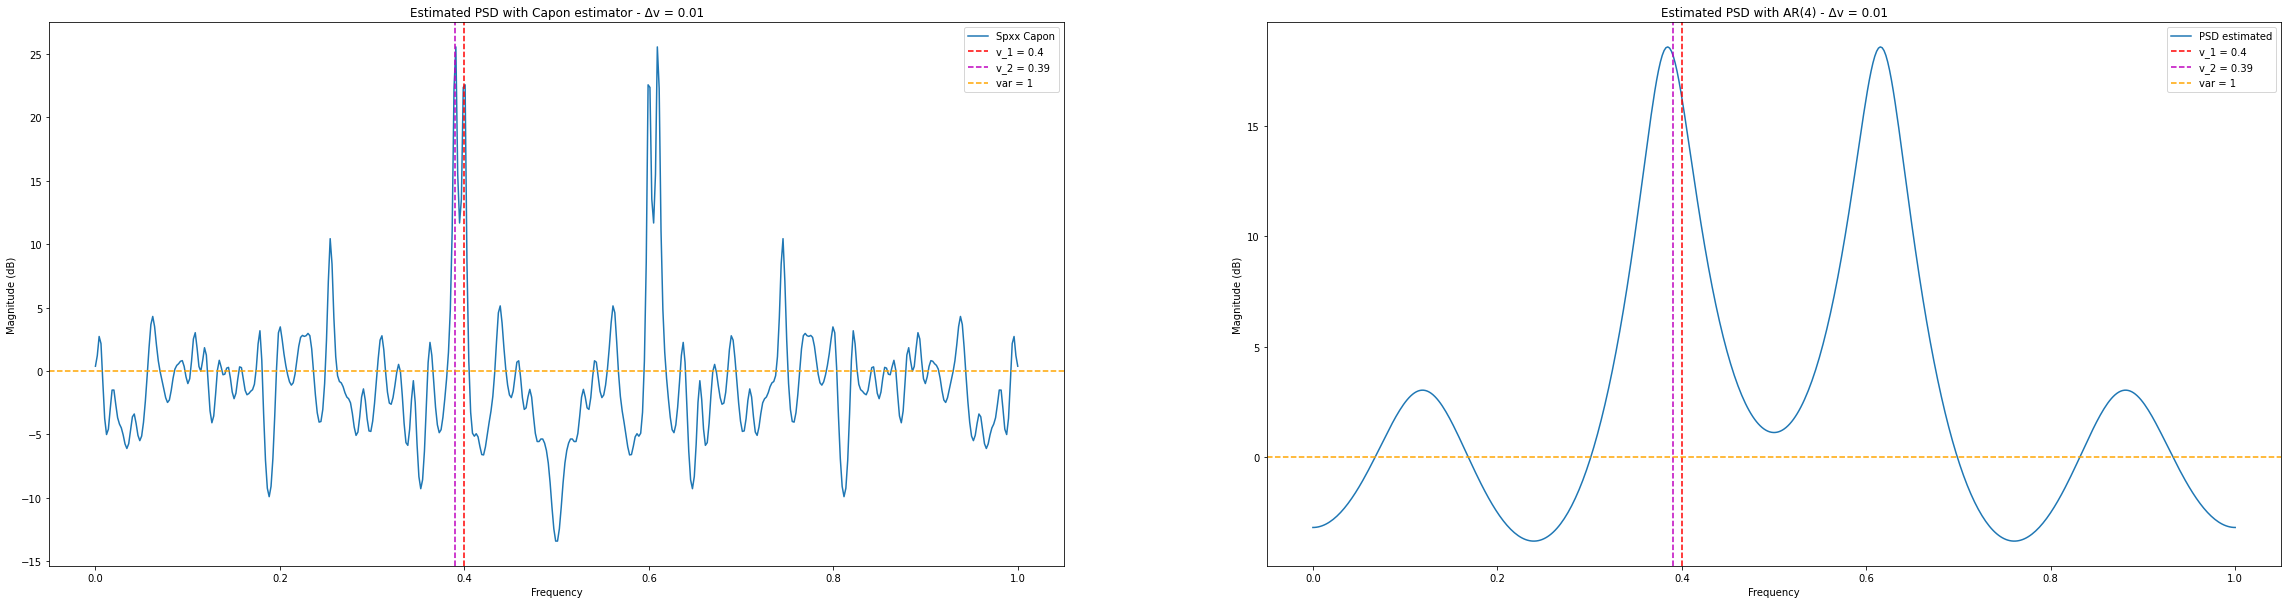

In [ ]:
for i in range(len(v2)):
  fig, axs = plt.subplots(1, 2,figsize=(40,10))
  axs[0].plot(np.linspace(0,1,len(Spcap[i])), 20*np.log10(Spcap[i]), label = 'Spxx Capon')
  axs[0].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[0].axvline(v2[i], color='m', ls='--',label=f'v_2 = {v2[i]}')
  axs[0].axhline(20*np.log10(var), color='orange', ls='--',label = f'var = {var}')
  axs[0].set_ylabel('Magnitude (dB)')
  axs[0].set_xlabel('Frequency')
  axs[0].legend()
  axs[0].set_title(f'Estimated PSD with Capon estimator - Δv = {round(delta[i],3)}')
  axs[1].plot(np.linspace(0,1,len(psd[i])), 20*np.log10(psd[i]), label = 'PSD estimated')
  axs[1].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[1].axvline(v2[i], color='m', ls='--',label=f'v_2 = {v2[i]}')
  axs[1].axhline(20*np.log10(var), color='orange', ls='--',label = f'var = {var}')
  axs[1].set_ylabel('Magnitude (dB)')
  axs[1].set_xlabel('Frequency')
  axs[1].legend()
  axs[1].set_title(f'Estimated PSD with AR(4) - Δv = {round(delta[i],3)}')
  plt.show()

In [ ]:
var_vect = [1,2.5,5,10]
N = 500
K = 2
amp = [1, 1]
phases = [0, 0]
var = 1
v1 = 0.4
v2 = 0.2
freq = [v1,v2]

Xt_vect = []
SNR = []
for i in range(len(var_vect)):
  Xt, SNR_i = SinusoidsSNR(N, K, freq, amp, phases, var_vect[i])
  Xt_vect.append(Xt)
  SNR.append(SNR_i)

Spcap = []
psd = []
for i in range(len(var_vect)):
  Spcap.append(CaponMethod(Xt_vect[i], 100, 500))
  #estimating the model with AR(4)
  estimated_coeff, sigma2Est = estimateAr(Xt_vect[i], 4)
  psd.append(PSD(sigma2Est,-estimated_coeff[1:],N))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: ComplexWarning: Casting complex values to real discards the imaginary part


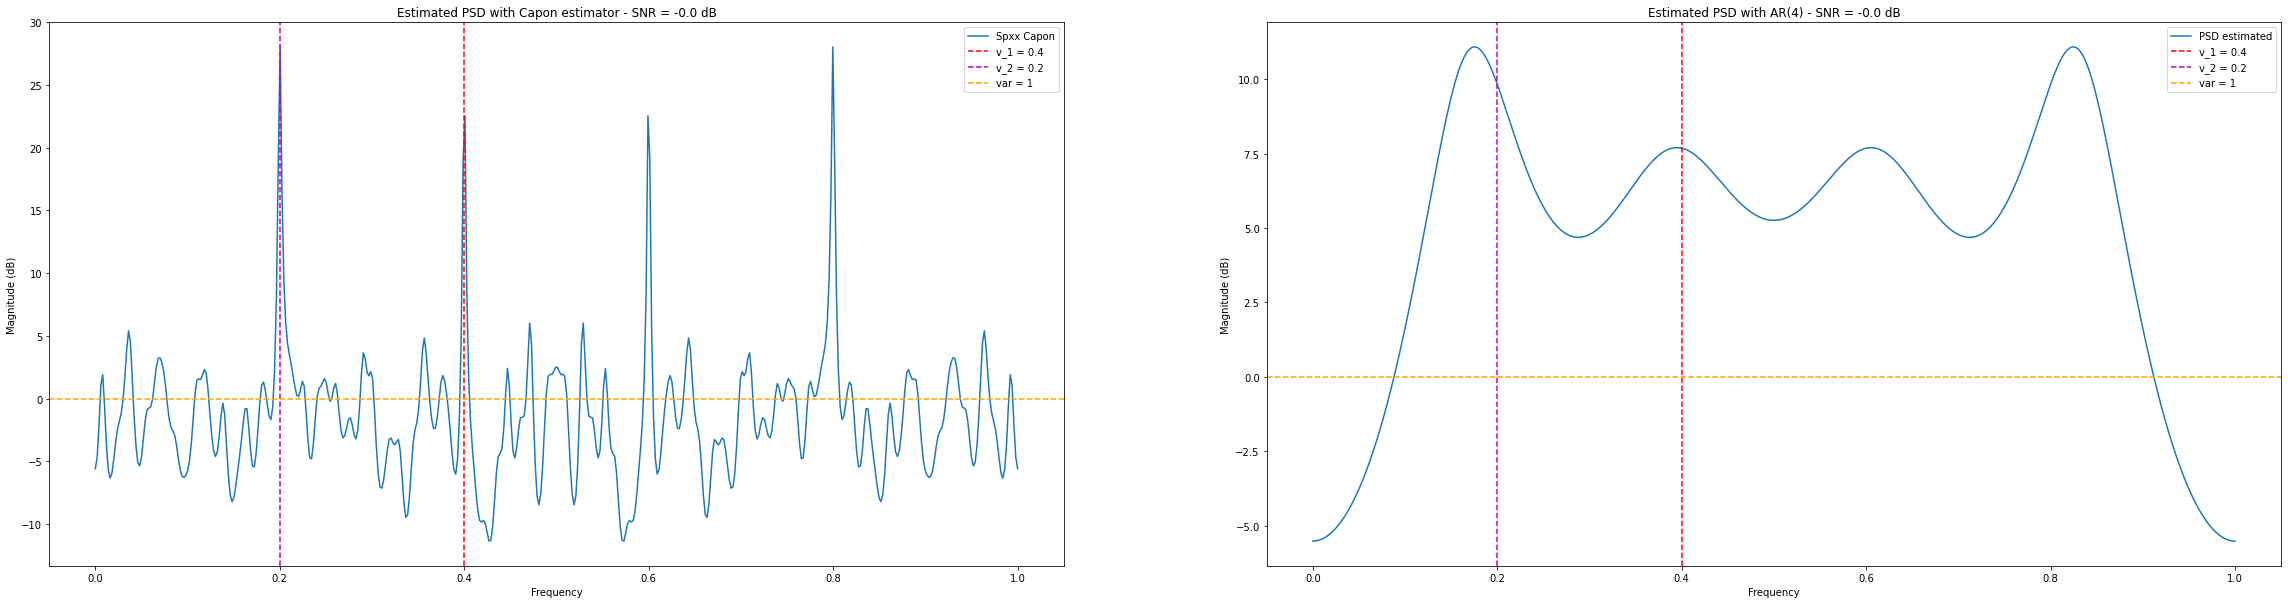

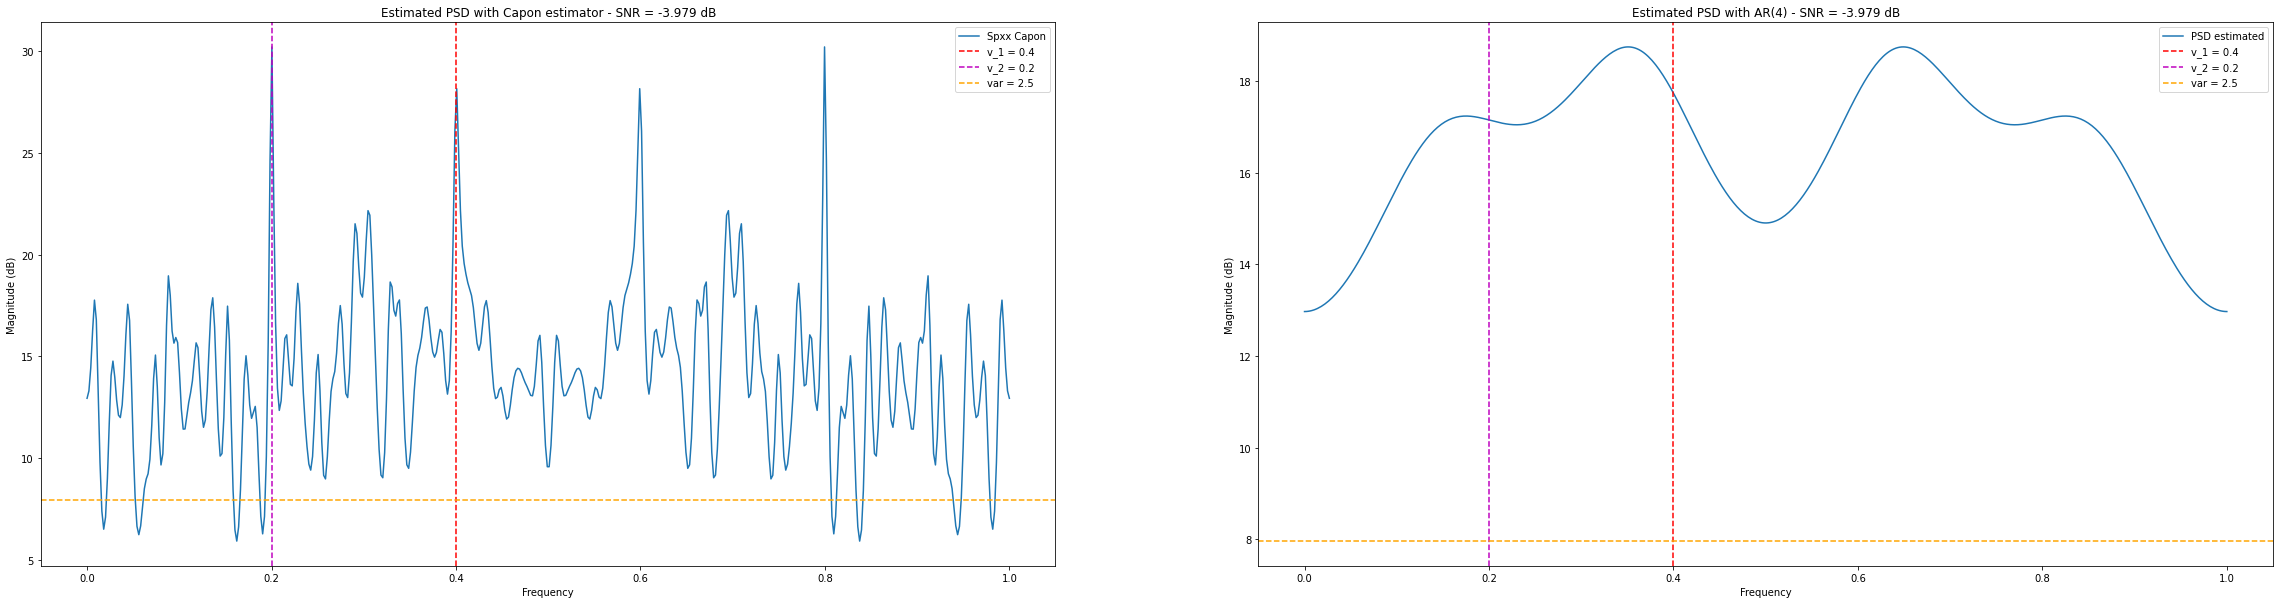

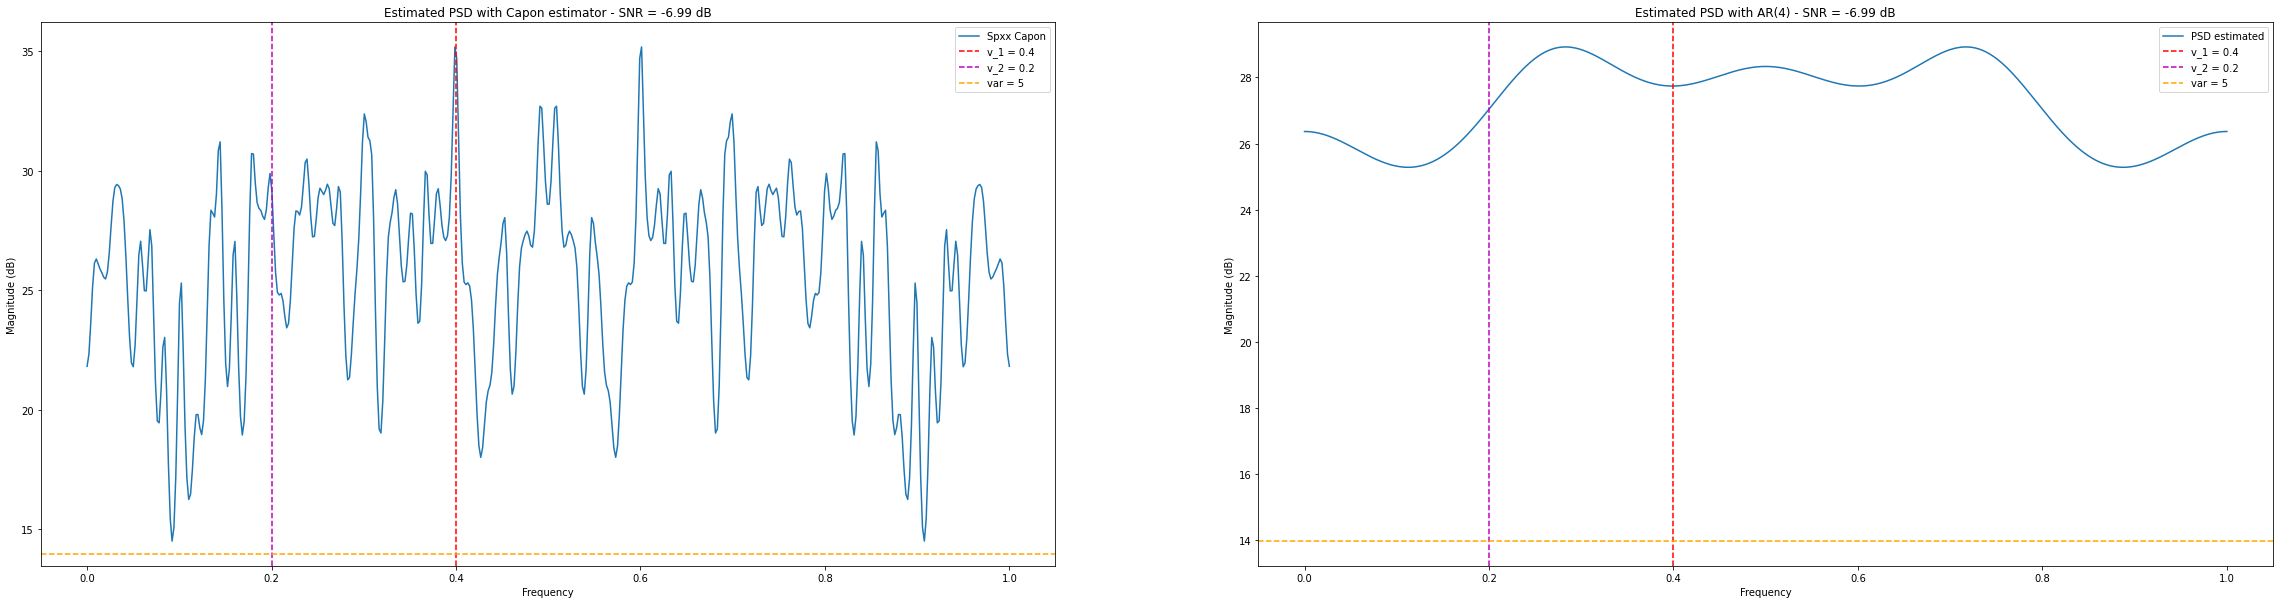

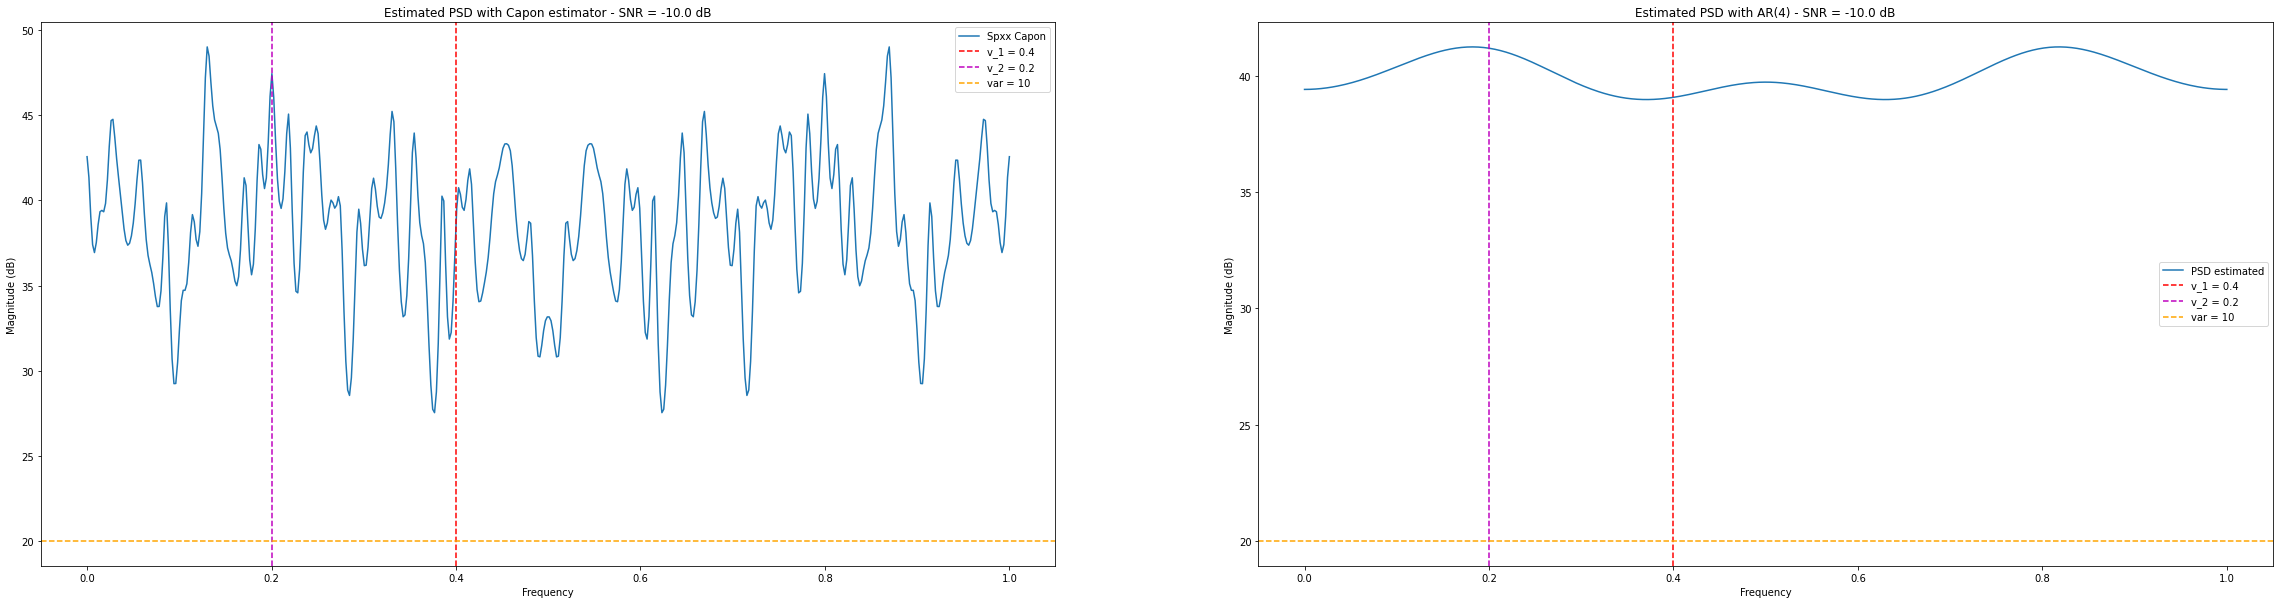

In [ ]:
for i in range(len(var_vect)):
  fig, axs = plt.subplots(1, 2,figsize=(40,10))
  axs[0].plot(np.linspace(0,1,len(Spcap[i])), 20*np.log10(Spcap[i]), label = 'Spxx Capon')
  axs[0].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[0].axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
  axs[0].axhline(20*np.log10(var_vect[i]), color='orange', ls='--',label = f'var = {var_vect[i]}')
  axs[0].set_ylabel('Magnitude (dB)')
  axs[0].set_xlabel('Frequency')
  axs[0].legend()
  axs[0].set_title(f'Estimated PSD with Capon estimator - SNR = {round(SNR[i],3)} dB')
  axs[1].plot(np.linspace(0,1,len(psd[i])), 20*np.log10(psd[i]), label = 'PSD estimated')
  axs[1].axvline(v1, color='r', ls='--', label=f'v_1 = {v1}')
  axs[1].axvline(v2, color='m', ls='--',label=f'v_2 = {v2}')
  axs[1].axhline(20*np.log10(var_vect[i]), color='orange', ls='--',label = f'var = {var_vect[i]}')
  axs[1].set_ylabel('Magnitude (dB)')
  axs[1].set_xlabel('Frequency')
  axs[1].legend()
  axs[1].set_title(f'Estimated PSD with AR(4) - SNR = {round(SNR[i],3)} dB')
  plt.show()

After comparing the Capon estimator with linear prediction using the AR(4) model, we can conclude that the Capon estimator presents a better spectral resolution. As the variance increases both methods do not perform well.

## **3 Autoregressive-moving-average process**

### **3.1 Synthesis**

The $ARMA(p,q)$ process is defined as:

$$ X_t = \sum_{i = 1}^p a_p X_{t-i} + \sum_{j = 1}^q a_p Z_{t-j} + Z_t $$ 

In [ ]:
#function to synthesize an ARMA process

def ARMA(N,var,a_coef,b_coef):
  Xt = np.zeros(N)
  Zt = np.random.normal(0, var, size = N)
  Xt[0] = Zt[0]
  for t in range(1,N):
    sum_AR = 0
    sum_MA = 0
    for i in range(1,len(a_coef) + 1):
      if(t - i >= 0):
        sum_AR += a_coef[i - 1]*Xt[t - i]

    for j in range(1,len(b_coef) + 1):
      if(t - j >= 0):
        sum_MA += b_coef[j - 1]*Zt[t - j]

    Xt[t] = sum_AR + sum_MA + Zt[t]
  
  return Xt

In [ ]:
var = 1
a1 = 0.5
b1 = 0.6
N = 500
Xt = ARMA(N,var,[a1],[b1])

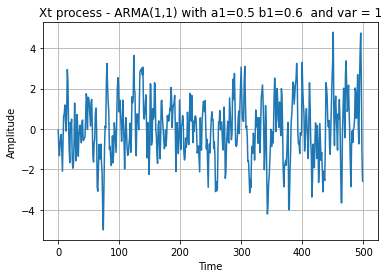

In [ ]:
plt.figure()
plt.title(f"Xt process - ARMA(1,1) with a1={a1} b1={b1}  and var = {var}")
plt.plot(Xt)
plt.grid()
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

### **3.2 Non-parametric estimation : periodogram**

In [ ]:
# Function to calculate PSD of the ARMA(1,1) process
def PSD_ARMA11(N, sigma, coeff_AR, coeff_MA):
  freq = np.linspace(0,1,N)
  psd = sigma * (abs((1 + coeff_MA * np.exp(-1j * 2 * np.pi * freq))/(1 - coeff_AR * np.exp(-1j * 2 * np.pi * freq)))**2)
  return psd, freq

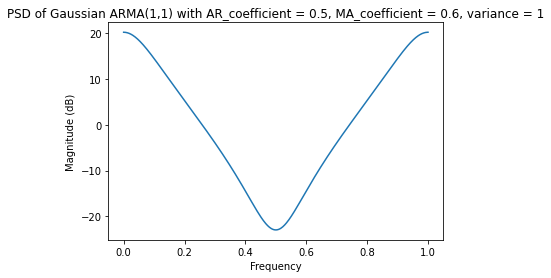

In [ ]:
# Calculating the psd
psd, freq = PSD_ARMA11(N, var, a1, b1)

# Plot the psd in dB
plt.plot(freq, 20*np.log10(psd))
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title(f'PSD of Gaussian ARMA(1,1) with AR_coefficient = {a1}, MA_coefficient = {b1}, variance = {var}')
plt.show()

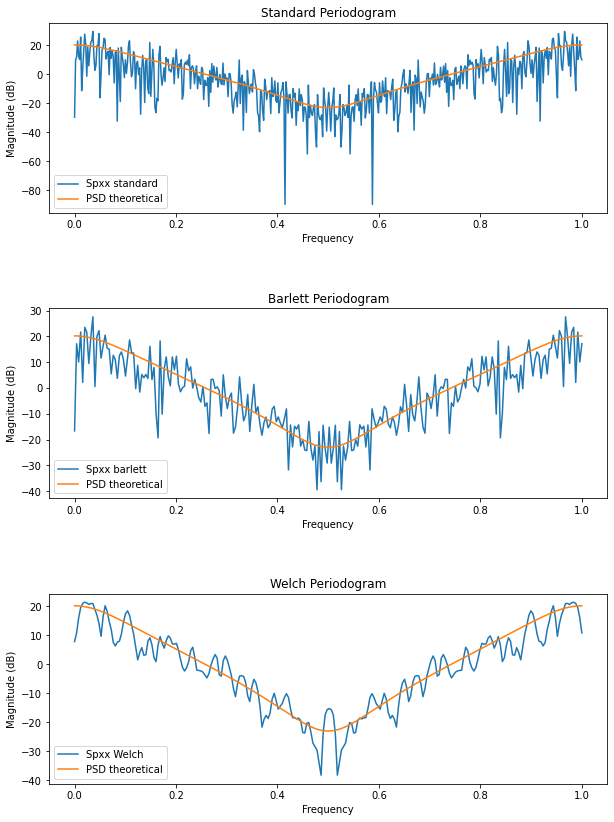

In [ ]:
# Display the periodograms obtained with the different methods
Spxx_std = Periodogram(Xt,'Standard')
Spxx_bartlett = Periodogram(Xt,'Bartlett', M=250)
Spxx_welch = Periodogram(Xt,'Welsh', M=250)

plt.figure(figsize=(10, 14))

# Plot of the standard periodogram in dB
plt.subplot(3, 1, 1)
plt.plot(np.linspace(0,1,len(Spxx_std)), 20*np.log10(Spxx_std), label = 'Spxx standard')
plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD theoretical')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('Standard Periodogram')
plt.legend()

# Plot of the Barlett periodogram in dB
plt.subplot(3, 1, 2)
plt.plot(np.linspace(0,1,len(Spxx_bartlett)), 20*np.log10(Spxx_bartlett), label = 'Spxx barlett')
plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD theoretical')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('Barlett Periodogram')
plt.legend()

# Plot of the welch periodogram in dB
plt.subplot(3, 1, 3)
plt.plot(np.linspace(0,1,len(Spxx_welch)), 20*np.log10(Spxx_welch), label = 'Spxx Welch')
plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD theoretical')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('Welch Periodogram')
plt.legend()

plt.subplots_adjust(hspace=.5)
plt.show()

We notice that the bartlett and welch methods decrease the smearing effect if compared to the standard estimator. We computed the bias and variance below and we observed that the estimators that have the closest PSD predicition to the theoretical one have a greater bias in absolute value and a smaller variance.

In [ ]:
#Calculating the Bias and  Variance 

#Standard Estimator
bias_std = np.mean(Spxx_std) - np.mean(psd)
var_std = np.var(Spxx_std)

print('** Standard Estimator **')
print('bias:', bias_std)
print('variance:', var_std)
print('\n')

#Bartlett Estimator
bias_B = np.mean(Spxx_bartlett) - np.mean(psd)
var_B = np.var(Spxx_bartlett)

print('** Bartlett Estimator **')
print('bias:', bias_B)
print('variance:', var_B)
print('\n')

#Welsh Estimator
bias_W = np.mean(Spxx_welch) - np.mean(psd)
var_W = np.var(Spxx_welch)

print('** Welsh Estimator **')
print('bias:', bias_W)
print('variance:', var_W)

** Standard Estimator **
bias: -0.3549796345754008
variance: 17.554402108985354


** Bartlett Estimator **
bias: -0.3549796345754008
variance: 12.848439676232815


** Welsh Estimator **
bias: -0.39541402091270994
variance: 8.98543631520492


### **3.3 Parametric estimation : Durbin method**

In this section, we will implement the durbin method to estimate ARMA parameters. First, we estimate AR(K) to compute the noise sequence $\hat e(t)$ of the MA model. Then, we obtain the parameters of the ARMA estimation from this sequence.

The vector $\hat \theta$ contains the ARMA estimated parameters and is given by the least squares solution:

$$\hat \theta = -(Z^* Z)^{-1}(Z^*z)$$

$$ \theta = [a_1, a_2, ... a_n | B_1, b_2, .., b_m]$$ 

Where Z  is the matrix containing values of y and e:

$$ z = [y(L+1), y(L-2), ..., y(N)]^T$$


 

In [ ]:
def estimation_MA(x, p):
    estimated_coeffs, sigma2Est = estimateAr(x, p)
    return sig.lfilter(estimated_coeffs, [1], x)

def Z_matrix(x, e, p, q, L):
    N = len(x)
    A = np.zeros((N - L, p))
    for i in np.arange(0, N - L):
        a = np.flip(x[L - p + i: L + i])
        A[i, :] = a
    B = np.zeros((N - L, q))
    for i in np.arange(0, N - L):
        b = - np.flip(e[L - p + i: L + i])
        B[i, :] = b
    return np.concatenate((A, B), axis=1)


def estimateARMA(x, p, q, L, k):
    # Generates noise sequence
    e = estimation_MA(x, k)
    # Constructs Z matrix
    z = x[L:]
    Z = Z_matrix(x, e, p, q, L)

    theta_hat = -np.linalg.inv(np.conjugate(Z.T).dot(Z)).dot(np.conjugate(Z.T)).dot(z)

    e_tilde = Z.dot(theta_hat) + z
    sigma2 = 1 / (N - L) * np.conjugate(e_tilde.T).dot(e_tilde)
    return theta_hat, sigma2

In [ ]:
# Estimates ARMA model
K = 125
L = K+1
p = 1
q = 1

theta_hat, sigma2 = estimateARMA(Xt, p, q, L, K)

# True PSD
psd_estimation_arma11, freq = PSD_ARMA11(N, sigma2, theta_hat[1], -theta_hat[0])

We can observe from the plots below that the Durbin estimator has great results for the ARMA PSD, that means the estimated values are closer to the theoretical one.

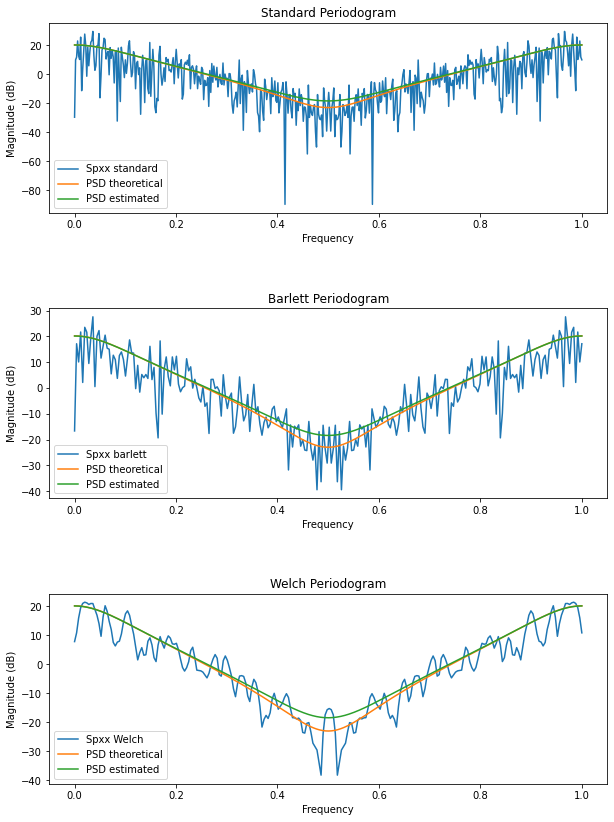

In [ ]:
# Display the periodograms obtained with the different methods
Spxx_std = Periodogram(Xt,'Standard')
Spxx_bartlett = Periodogram(Xt,'Bartlett', M=250)
Spxx_welch = Periodogram(Xt,'Welsh', M=250)

plt.figure(figsize=(10, 14))

# Plot of the standard periodogram in dB
plt.subplot(3, 1, 1)
plt.plot(np.linspace(0,1,len(Spxx_std)), 20*np.log10(Spxx_std), label = 'Spxx standard')
plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD theoretical')
plt.plot(freq, 20*np.log10(psd_estimation_arma11), label = 'PSD estimated')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('Standard Periodogram')
plt.legend()

# Plot of the Barlett periodogram in dB
plt.subplot(3, 1, 2)
plt.plot(np.linspace(0,1,len(Spxx_bartlett)), 20*np.log10(Spxx_bartlett), label = 'Spxx barlett')
plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD theoretical')
plt.plot(freq, 20*np.log10(psd_estimation_arma11), label = 'PSD estimated')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('Barlett Periodogram')
plt.legend()

# Plot of the welch periodogram in dB
plt.subplot(3, 1, 3)
plt.plot(np.linspace(0,1,len(Spxx_welch)), 20*np.log10(Spxx_welch), label = 'Spxx Welch')
plt.plot(np.linspace(0,1,len(psd)), 20*np.log10(psd), label = 'PSD theoretical')
plt.plot(freq, 20*np.log10(psd_estimation_arma11), label = 'PSD estimated')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('Welch Periodogram')
plt.legend()

plt.subplots_adjust(hspace=.5)
plt.show()

### **3.4 Application to speech signals**



In [ ]:
data_path = os.getcwd()
filename = 'an_in_on.wav'
sound = os.path.join(data_path, filename) 
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=16000, nframes=28270, comptype='NONE', compname='not compressed')


In [ ]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
x = np.array(data)
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

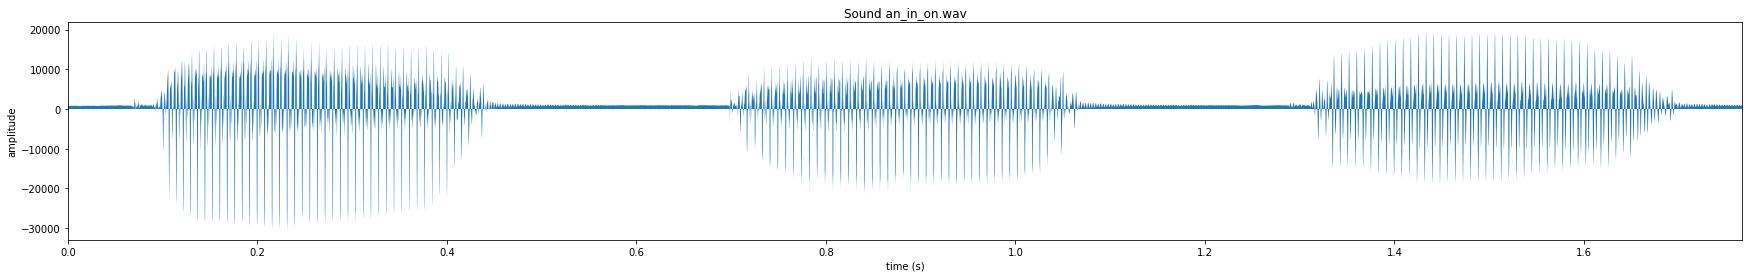

In [ ]:
plot_sound(x, times, 'Sound an_in_on.wav')

In [ ]:
Audio(x, rate = Fs)

In [ ]:
wavObject = wave.open(filename)
frames = wavObject.readframes(wavefile.getnframes())
an = np.frombuffer(frames[2700:15000], dtype='int16')/32768.

In [ ]:
Audio(an, rate = Fs)

In [ ]:
#Estimating the parameters of the audio containing an sound
K = 500
L = K+1
p = 1
q = 1
N = len(an)
estimated_coeff, sigma2Est = estimateARMA(an, p, q, L, K)
psd_estimated_an, freq = PSD_ARMA11(N, sigma2Est, estimated_coeff[1], -estimated_coeff[0])

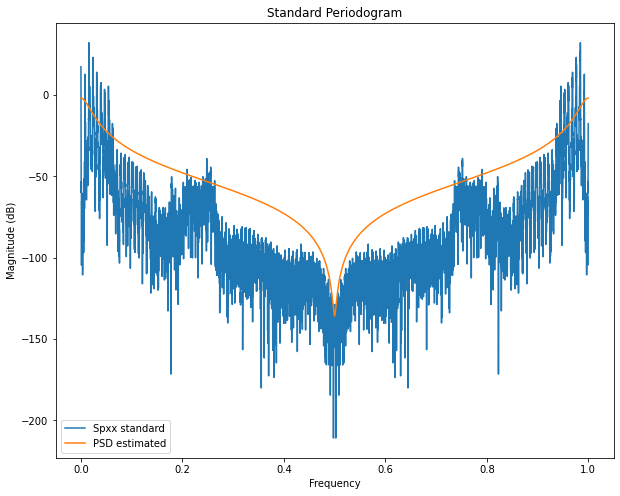

In [ ]:
# Display the periodograms obtained with the different methods
Spxx_std = Periodogram(an,'Standard')

plt.figure(figsize=(10, 8))
# Plot of the standard periodogram in dB
plt.plot(np.linspace(0,1,len(Spxx_std)), 20*np.log10(Spxx_std), label = 'Spxx standard')
plt.plot(freq, 20*np.log10(psd_estimated_an), label = 'PSD estimated')
plt.ylabel('Magnitude (dB)')
plt.xlabel('Frequency')
plt.title('Standard Periodogram')
plt.legend()
plt.show()

We can observe from the graph above that the sound wave can be roughly estimated by the ARMA method. The content of the estimated spectra has a similar shape to the periodogram.